# Interval Methods for Contrained Satisfaction Programming

This notebook is based on the [iamooc]().

pyibex is available from [github](https://github.com/benEnsta/pyIbex) and can be installed with `pip install pyibex`. Some information is available [here](https://libraries.io/pypi/pyibex)

# Set arithmetic and interval computation

In [179]:
from math import inf, isnan, exp, log, sqrt

The next cell introduces all the mathematics related to interval analysis [Moo66]. 

In [207]:
nan = float('nan')
oo  = float( inf )


class Interval:
    def __init__(self, lo=nan, up=nan):
        #assert lo <= up, f'lo is {lo} and should be less than the up value {up}'
        if lo > up:
            # we accept this but the corresponding interval is empty
            self.empty()
            #self.lo = nan
            #self.up = nan
        else:
            self.lo = lo
            self.up = up   
    
    def empty(self):
        self.lo = nan
        self.up = nan
    
    def isempty(self):
        # empty set is when lower bound or upper bound are nan
        return isnan(self.lo)
        
    def __add__(self, y):
        return Interval(self.lo+y.lo, self.up+y.up)
    
    def __sub__(self, y):
        return Interval(self.lo - y.up, self.up - y.lo)
        
    def __mul__(self, y):
        res = [self.lo*y.lo, self.lo*y.up, self.up*y.lo, self.up*y.up]
        return Interval(min(res), max(res))
    
    def __rmul__(self, y):
        return self.__mul__(Interval(y, y))
    
    def __truediv__(self, y):
        if 0 in y:
            return Interval(-inf, inf)
        else:
            return self*Interval(1./y.up, 1./y.lo)
        
    def __contains__(self, y):
        return (self.lo <= y <= self.up)
    
    def __repr__(self):
        return f'[{self.lo}, {self.up}]'

    def __eq__(self, y):
        if self.isempty() & y.isempty(): return True
        return self.lo == y.lo and self.up == y.up        
    
    def __and__( self, y ): # intersection of two intervals
        if self.isempty() | y.isempty():
            return Interval( nan, nan ) # empty interval
        else:
            return Interval( max(self.lo, y.lo), min(self.up, y.up) ) 
    
    def __or__( self, y ): # union of two intervals
        if self.isempty():
            return y
        if y.isempty():
            return self          
        return Interval( min(self.lo, y.lo), max(self.up, y.up) ) 
                            
    
    def width(self):
        return (self.up - self.lo)
    
    def left(self):
        return Interval(self.lo, (self.up+self.lo)/2.)

    def right(self):
        return Interval((self.up+self.lo)/2., self.up)
        
    def is_subset(self, y):
        if self.isempty():
            return True
        else:
            return (self.lo in y) & (self.up in y)
        
    def is_disjoint(self, y):
        return (self & y).isempty() # if the intersection (&) is empty, they are disjoint                                                                                            
    
    @staticmethod
    def sqr(x):
        res = [x.lo**2, x.up**2]
        if 0 in x:
            return Interval(0, max(res))
        else:
            return Interval(min(res), max(res))
        
    @staticmethod
    def sqrt(x):
        x = x & Interval(0, inf)
        return Interval(sqrt(x.lo), sqrt(x.up))
        
    @staticmethod
    def exp(x):
        return Interval(exp(x.lo), exp(x.up))

    @staticmethod
    def log(x):
        if x.up < 0:
            return Interval() # empty interval        
        elif 0 in x:
            return Interval(-inf, log(x.up))
        else:
            return Interval(log(x.lo), log(x.up))
    
    @staticmethod
    def min(x, y):
        return Interval(min(x.lo, y.lo), min(x.up, y.up))

    @staticmethod
    def max(x, y):
        return Interval(max(x.lo, y.lo), max(x.up, y.up))
    
    

In [214]:
a = Interval(4., 5)
b = Interval(3, 4)
x = Interval(-2, 2)
y = Interval()

assert a.width() == 1
assert Interval.sqr(a) == Interval(16.0, 25.)
assert Interval.exp(a) == Interval(54.598150033144236, 148.4131591025766)
assert Interval.log(Interval(-3, -1)) == Interval(nan, nan)
assert Interval.log(Interval(4, 5)) == Interval(1.3862943611198906, 1.6094379124341003)
assert Interval.sqr(x) + 2*x - Interval.exp(x) == Interval(-11.38905609893065, 7.864664716763388)
assert y == Interval(nan, nan)

assert a.right() == Interval(4.5, 5.)
assert a.left() == Interval(4, 4.5)

assert a & b != a and b # Note: we only overloaded __and__ which is &

assert Interval(4., 5).is_subset(Interval(0, 10)) == True
assert Interval(4., 5).is_subset(Interval(5, 10)) == False
assert Interval(4., 5).is_disjoint(Interval(6, 10)) == True
assert Interval(4., 5).is_disjoint(Interval(3, 10)) == False

## Set Inversion

Many problems of engineering such as parameter estimation, tuning of a controller, etc., can be cast into a set inversion problem. In this chapter, we will define the notions of set inversion and illustrate these notions on some examples. An algorithm for solving any set inversion problems will be given. This algorithm, named SIVIA (Set Inverter Via Interval Analysis), will be proposed. This algorithm will be implemented in Python and some test-cases will be solved.

How can I calculate the set:

$X = f^{-1}(Y) = \{ x \in X | f(x) = Y \}$

Example:

$x_1^2 + x_2 \in [1, 2]$

$sin(x_1x_2) \le 1$

In this case, $Y = [1,2] x [-inf, 1]$

### Inclusion test

Inclusion tests are used to verify if a box is inside or outside a set.

The following conditions can be implemented in an algorithm:

if $[f]([x]) \subset Y$, then $[x] \subset X$

if $[f]([x]) \cap Y = 0 $, then $[x] \cap X = 0$

where $[f](.)$ is the inclusion function that maps the set $f([x])$, which is the image of $[x]$ in $Y$ through $f$ which might not be a box, into a box.

The boxes for which these two tests failes can be bisected (reduced in size) to see if some of them are instead part of the solution (unless they are too small)

![set-inversion](pics/csp/inclusion-tests.png)

### SIVIA Algorithm - Set Inversion Via Interval Analysis

This algorithm solves the set inversion problem using interval analysis.

Given a know set $Y$

I want to calculate the set $X= f^{-1}(Y)$.

The set $X$ can be approximated by two subpavings:

$X^- \subset X \subset X^+$

**Algorithm**

Initalise the list of boxes $L=[x_0]$, where $[x_0]$ is the initial box (e.g. the entire domain).

Note that this initial box will not satisfy the inclusion test (it will fall under step 3), and it will be bisected. This means that rapidly we will end up with a number of small boxes that go around the frontier of the set $X$.

`WHILE $L$ is not empty:`  
 
0. pull a box $[x]$ from $L$

1. box [x] inside the solution set $X$. In this case the two inclusion tests above will succeed.

       Step: 
if $[f]([x]) \subset Y$ then store in $X^-$ and $X^+$.


2. box [x] outside the solution set $Y$. In this case, $[f]([x]) \cap Y = 0 $ (image is out of $Y$).

       Step: 
if $[f]([x]) \subset Y = 0$, then discard $[x]$

       
3. box [x] on a bit inside, and a bit outside. $[x]$ would fail both tests. In this case, we bisect $[x]$ into two subboxes.

       Step: 
bisect $[x]$ into boxes $[x_1]$, $[x_2]$ and store $[x_1]$, $[x_2]$ in the "list of boxes $L$"


4. if a box is very small (less than $\eps$) and is on the frontier on the set $X$, then we cannot conclude anything using our tests, and we need to stop bisecting.

       Step: 
if $width([x]) < \eps$, store $[x]$ in $X^+$.

       
5. if $L$ is not empty, go to step 0.

if $\Delta X$ is the union of all the boxes on the frontier (yellow in the figure below), and if $X^-$ is the union of all the boxes inside $X$ (red in figure below), then:

$X^- \subset X \subset X \cup \Delta X$, where $X \cup \Delta X = X^+$

![subpaving](pics/csp/subpavings.png)

## Parameter Estimation And Set Inversion

Assumption: all errors are bounded.

Suppose you have a model:

$y(t) = p_1exp^{-p_2t}$

and some measurements:

y(t_1) =  5 + $[-n_1, n_1]$  
y(t_2) =  2 + $[-n_2, n_2]$  
y(t_3) =  6 + $[-n_3, n_3]$  


where $[-n_i, n_i]$ is the noise interval with which I can measure the variables.

We can also define a "simulator" $f$, which, given any parameter vector of our model $(p_1, p_2)$, returns the associated output:

$f(\hat{p}_1, \hat{p}_2)= ( \hat{p}_1exp^{- \hat{p}_2t_1}; \hat{p}_1exp^{-\hat{p}_2t_2};  \hat{p}_1exp^{- \hat{p}_2t_3} )$

In this respect, if $[y]$ is the box obtained as the cartesian product of the intervals of the output variables $y(t_1) x y(t_2) x y(t_3)$, then:

$P = f^-1([y])$

Hence, in a bounded error problem, parameter estimation is a set inversion problem.

![param-estimation](pics/csp/param-estimation.png)

# Non-convex global minimization

Interval analysis allows to solve non-convex global minimization problems [Kea96] without being trapped by a local minimum [Nin11].

In [4]:
from vibes import *  # to draw intervals.

import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Drawing boxes

In [16]:
# Create figure and axes
def _draw_box(x_lo, x_up, y_lo, y_up, edgecolor='black', facecolor='blue', ax=None):
    if ax is None: ax = plt.gca()        
    xy = (x_lo,y_lo)    
    width  = x_up-x_lo
    height = y_up-y_lo
    # Create a Rectangle patch
    rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor=edgecolor,facecolor=facecolor)
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.autoscale()
    return ax

def draw_box(b, edgecolor='black', facecolor='blue', ax=None):
    return _draw_box(b.x.lo, b.x.up, b.y.lo, b.y.up, edgecolor, facecolor, ax)

<IPython.core.display.Javascript object>


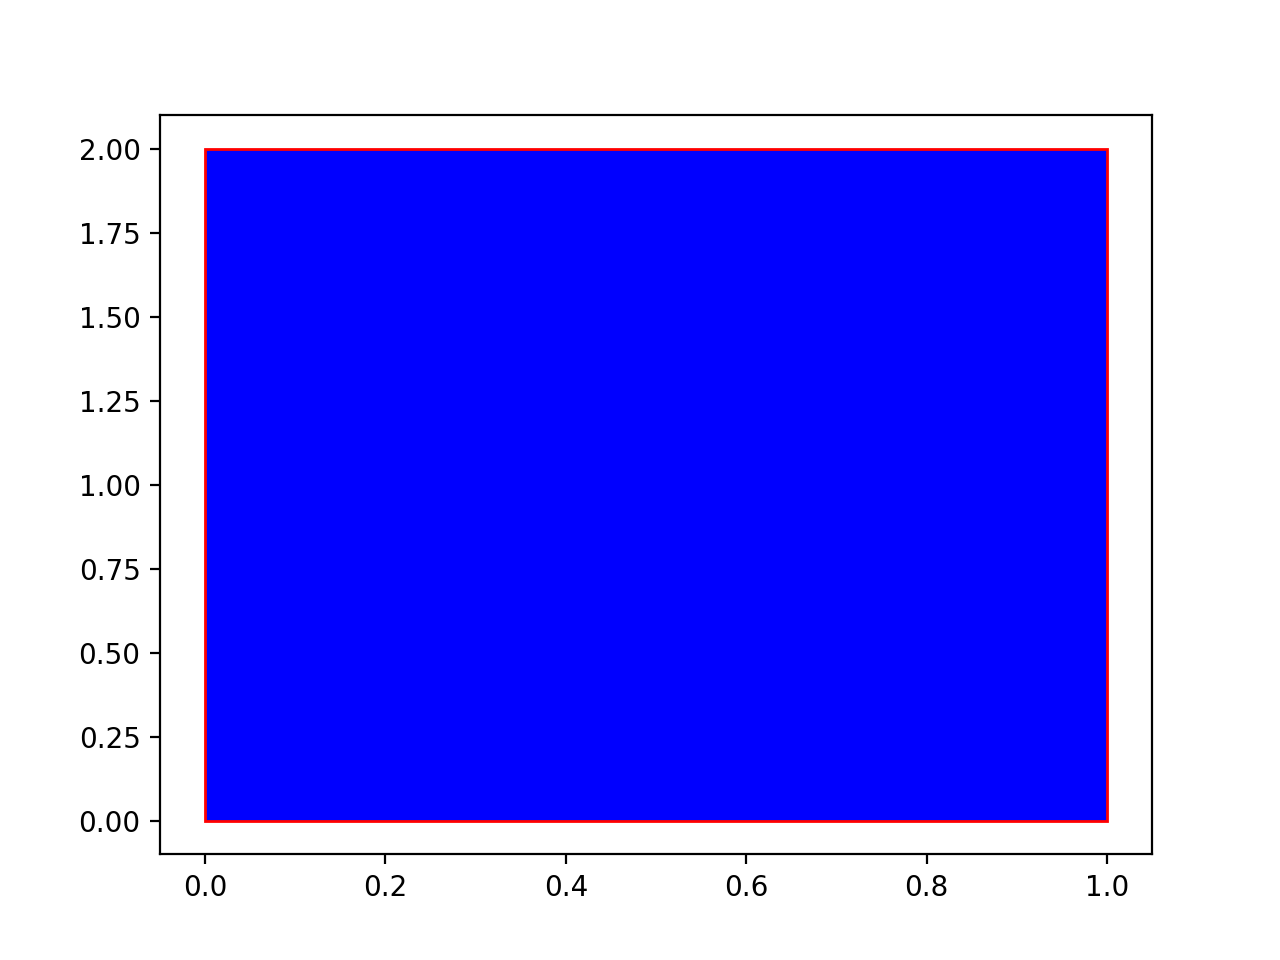

In [17]:
fig, ax = plt.subplots(1)
_draw_box(0, 1, 0, 2, 'red');

## Find the global minimum and draw

In [7]:
def a_function(tmin, tmax, dt, edgecolor='black', facecolor='blue', ax=None):
    t = tmin
    minimum = Interval(inf, inf)
    while t < tmax:
        x = Interval(t, t+dt)
        y = Interval.sqr(x) + 2*x - Interval.exp(x)
        # vibes.drawBox(x.lo, x.up, y.lo, y.up, color)
        _draw_box(x.lo, x.up, y.lo, y.up, edgecolor, facecolor)
        t += dt
        minimum = Interval.min(minimum, y)
    return minimum

accuracy 0.5, minimum: [-2.3678794411714423, -0.36787944117144233]
accuracy 0.05, minimum: [-1.509866552741015, -1.3098665527410147]
accuracy 0.005, minimum: [-1.420113068311228, -1.400113068311228]


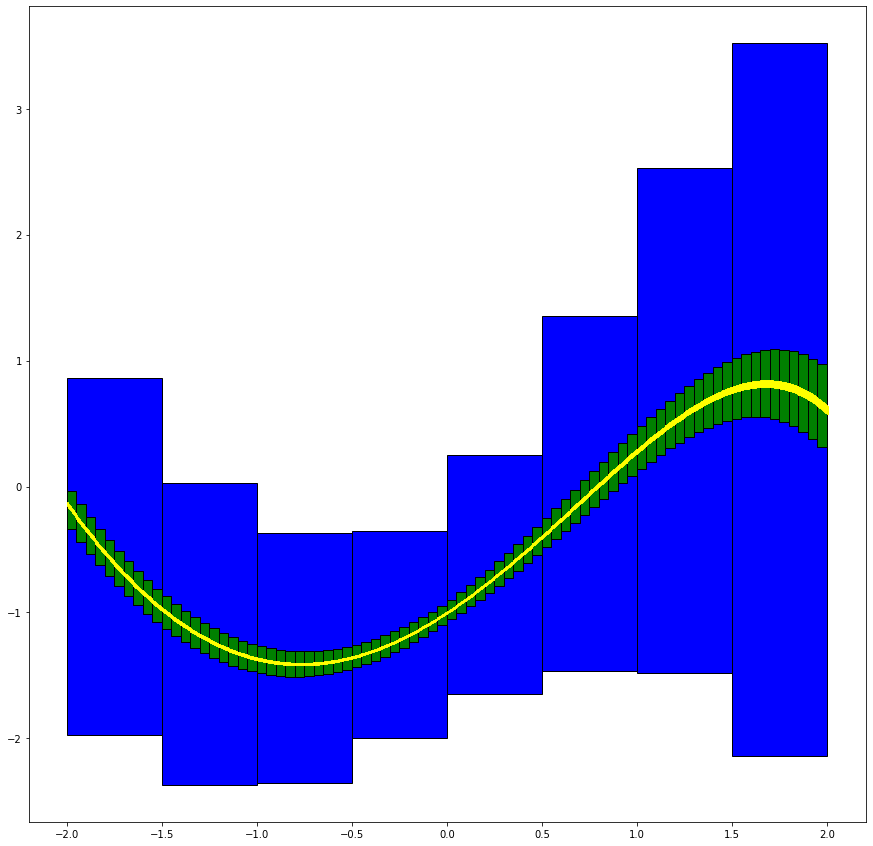

In [8]:
# The following would be the lines in vibes.
# vibes.beginDrawing() # init vibes
# vibes.newFigure('my-minimiser')
# drawtube(-2,2,1,['blue'])
# vibes.endDrawing()

fig, ax = plt.subplots(1,figsize=(15,15))
m = a_function(-2,2,0.5,edgecolor='black', facecolor='blue', ax=ax)
print(f'accuracy 0.5, minimum: {m}')
m = a_function(-2,2,0.05,edgecolor='black', facecolor='green', ax=ax)
print(f'accuracy 0.05, minimum: {m}')
m = a_function(-2,2,0.005,edgecolor='yellow', facecolor='yellow', ax=ax)
print(f'accuracy 0.005, minimum: {m}')

## Parameter estimation

In [9]:
class Box:
    def __init__(self, x:Interval, y:Interval):
        self.x = x
        self.y = y
        
    def width(self):
        if self.x.isempty() or self.y.isempty(): return -inf
        else:
            return max([self.x.width(), self.y.width()])
        
    def left(self):
        if self.x.width() > self.y.width():
            return Box(self.x.left(), self.y)
        else:
            return Box(self.x, self.y.left())
    
    def right(self):
        if self.x.width() > self.y.width():
            return Box(self.x.right(), self.y)
        else:
            return Box(self.x, self.y.right())           
        
    def __repr__(self):
        return f'[{self.x.lo},{self.x.up}] x [{self.y.lo},{self.y.up}]'

In [10]:
b = Box(Interval(1,2), Interval(2,4))
c = Box(Interval(), Interval(2,3))

print(b, c)
assert b.width() == 2
assert c.width() == -inf

[1,2] x [2,4] [nan,nan] x [2,3]


## Parameter estimation 

In [33]:
# color legend:
# red inside, blue outside, yellow not known

def inclusion_test(p):
    """Count number of intervals p is consistent with."""
    b = Interval(0, 0)
    for i in range(len(Y)):
        #pdb.set_trace()
        ti = T[i]
        yi = Y[i]
        fi = p.x*Interval.exp(ti*p.y) # model
        if fi.is_subset(yi):
            # result of the model fits completely within the measurement interval. add +1 to LB. Note that if there is only partial overlap add +0 to LB
            b.lo += 1
        if not(fi.is_disjoint(yi)): # intersection is not empty
            # in this case includes two things: model fits completely within the measurement interval: add +1 UB, 
            # or there is only a partial overlap: through the two instructions (see if subset above) I am adding [0, 1] as interval for partial overlap
            b.up += 1
    return b                                              
    
def sivia(p, eps=.01):
    b = inclusion_test(p) # b will tell us the number of measurements we are consisent with (as an interval, so as minimum and max)
    #pdb.set_trace()
    # check if I am consisent with all measurements (len(Y))
    if b.up < len(Y): 
        # in this case there is at least 1 measurement that we are not consistent with. It means that the box we are analysing is out of the box obtained as cartesian product of the measurement intervals.
        draw_box(p, edgecolor='black', facecolor='cyan')  
    elif b.lo >= len(Y):
        # in this case we are consistent with all measurements (we are inside of the set)
        draw_box(p, edgecolor='black', facecolor='red')             
    elif p.width() < eps:
        draw_box(p, edgecolor='yellow', facecolor='yellow')     
    else:
        # we bisect and call sivia again.
        sivia(p.left(), eps, q)
        sivia(p.right(), eps, q)

<IPython.core.display.Javascript object>


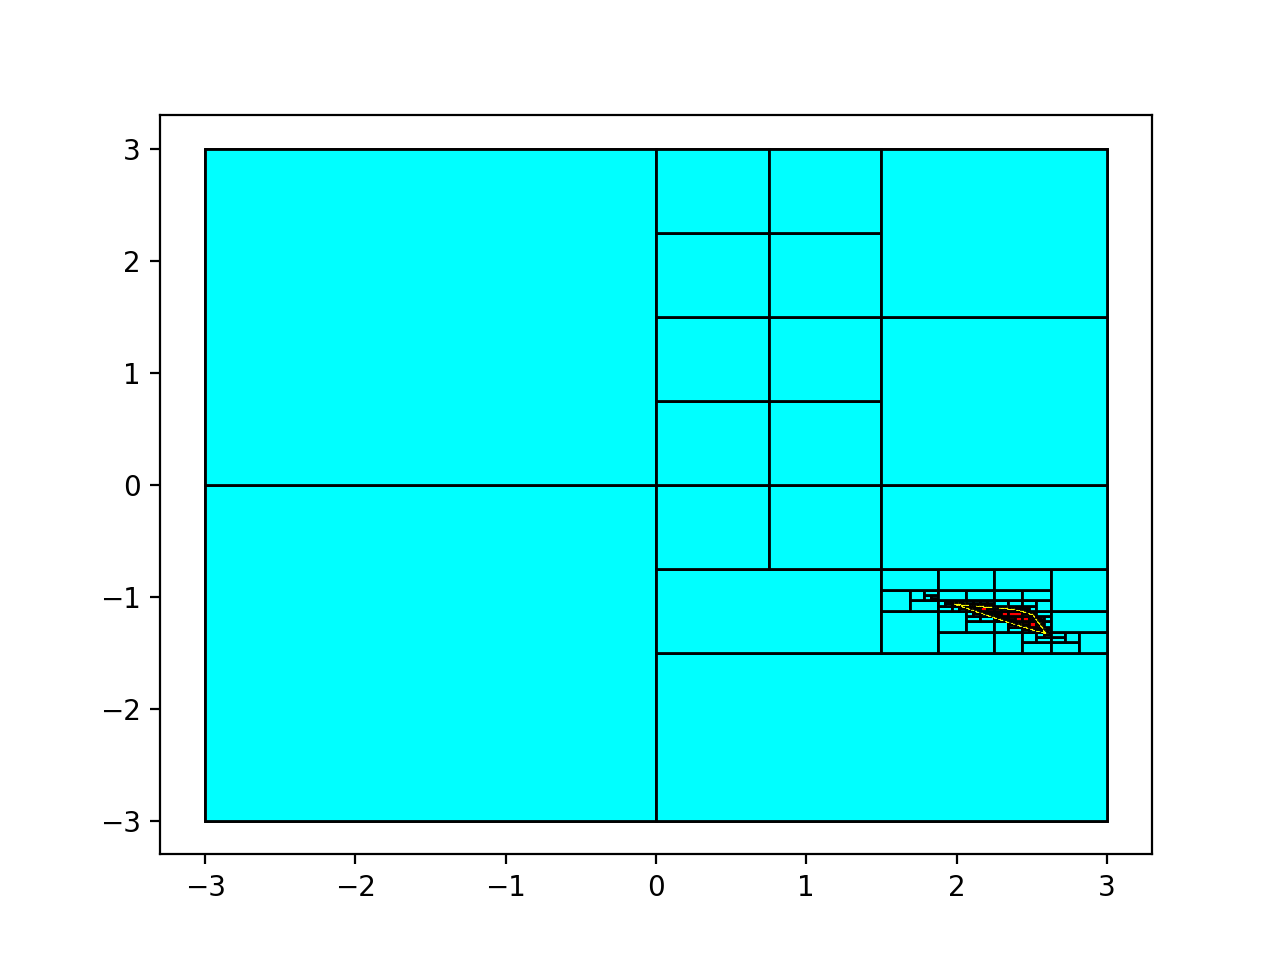

In [39]:
%matplotlib notebook
fig, ax = plt.subplots(1)

# time
T = [0.2, 1, 2, 4] 

# measurements
Y = [Interval(1.5, 2), 
     Interval(0.7, 0.8), 
     Interval(0.1, 0.3), 
     Interval(-0.1, 0.03)] 

# prior (initial box where my parameters belong)
P = Box(Interval(-3, 3), Interval(-3, 3))

# set inversion algorithm
sivia(P)

## Relaxing constraints 

This is equivalent to say that we can accept a certain number of outliers.

if q=0, no outliers (consistent with all measurements)  
if q=1, 1 outlier (consistent with all measurements but 1)  
...

The following code adds one parameter to the sivia algorithm and runs it.

In [52]:
def sivia(p, eps=.01, q=0):   
    b = inclusion_test(p) # b will tell us the number of measurements we are consisent with (as an interval, so as minimum and max)    
    # check if I am consisent with all measurements (len(Y))
    if b.up < len(Y) - q: 
        # in this case there is at least 1 measurement that we are not consistent with. It means that the box we are analysing is out of the box obtained as cartesian product of the measurement intervals.
        draw_box(p, edgecolor='black', facecolor='cyan')  
    elif b.lo >= len(Y) - q:
        # in this case we are consistent with all measurements (we are inside of the set)
        draw_box(p, edgecolor='black', facecolor='red')             
    elif p.width() < eps:
        draw_box(p, edgecolor='yellow', facecolor='yellow')     
    else:
        # we bisect and call sivia again.
        sivia(p.left(), eps, q)
        sivia(p.right(), eps, q)

<IPython.core.display.Javascript object>


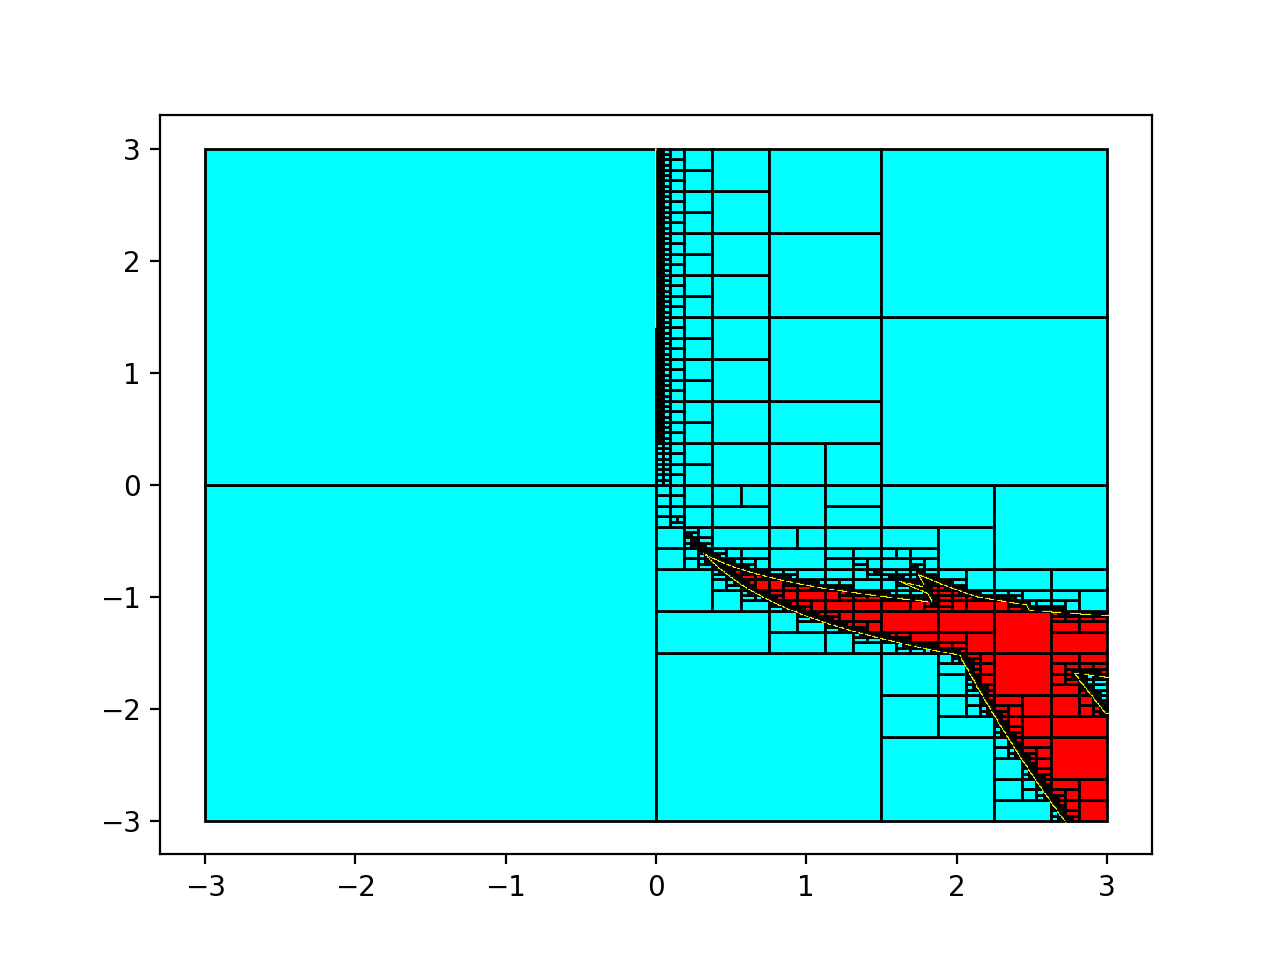

In [58]:
%matplotlib notebook
fig, ax = plt.subplots(1)


sivia(P, eps=0.01, q=2)

In [130]:
import random

def draw_output(P, t0=0, dt=0.05, tf=5, ax=None, color='green'):
    draw_output.counter += 1
    t = 0
    while t<=tf:
        T = Interval(t, t+dt)
        y = P.x*Interval.exp(T*P.y) # model
        draw_box(Box(T, y), edgecolor=color, facecolor=color, ax=ax)
        t += dt
draw_output.counter = 0
        
def sivia(p, eps=.1, q=0, lc=['green','blue','yellow','cyan','magenta']):   
    b = inclusion_test(p) # b will tell us the number of measurements we are consisent with (as an interval, so as minimum and max)    
    # check if I am consisent with all measurements (len(Y))
    if b.up < len(Y) - q: 
        # in this case there is at least 1 measurement that we are not consistent with. It means that the box we are analysing is out of the box obtained as cartesian product of the measurement intervals.
        draw_box(p, edgecolor='black', facecolor='cyan', ax=ax_i)  
    elif b.lo >= len(Y) - q:
        # in this case we are consistent with all measurements (we are inside of the set)
        draw_box(p, edgecolor='black', facecolor='red', ax=ax_i)         
    elif p.width() < eps:
        draw_box(p, edgecolor='yellow', facecolor='yellow', ax=ax_i)  
        draw_output(p, ax=ax_o, color=lc[draw_output.counter % len(lc)])
    else:
        # we bisect and call sivia again.
        sivia(p.left(), eps, q)
        sivia(p.right(), eps, q)

<IPython.core.display.Javascript object>


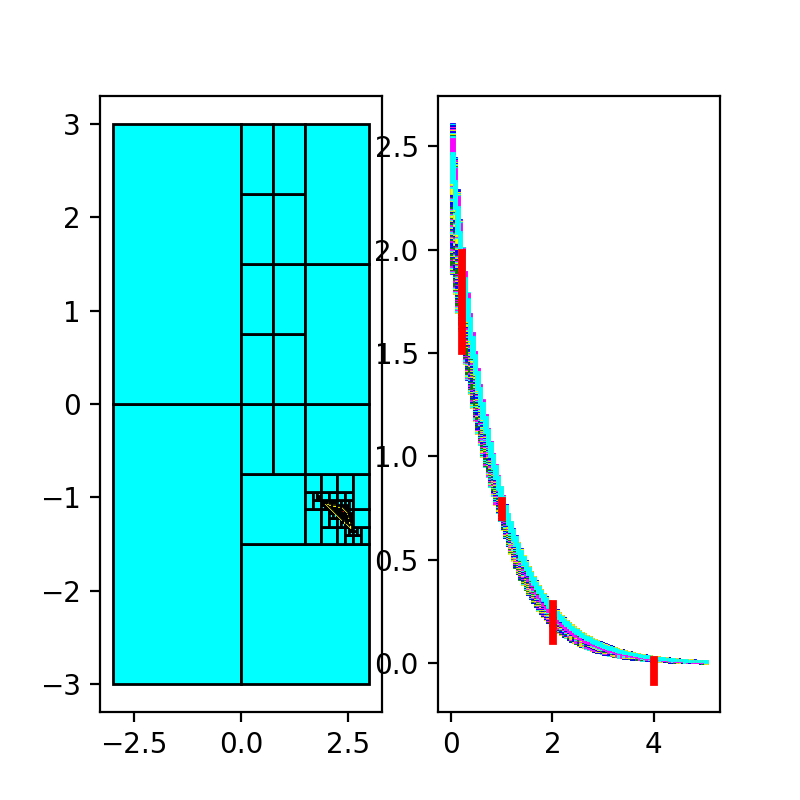

In [132]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(8,8))

Done = False

ax_i = ax[0] #Y
ax_o = ax[1]

sivia(P, eps=0.01, q=0, lc=['green','blue','yellow','cyan','magenta'])

# and now we print the model itself.
for i in range(len(Y)):    
    _draw_box(T[i]-0.05,T[i]+0.05, Y[i].lo, Y[i].up, edgecolor='red', facecolor='red', ax=ax_o)  

    

The left plot shows the solution set. The right plot shows the output of the model (time t and measurement interval Y) and the output. Sometimes the databar is larger and to have a more accurate interval measurement we need to intersect.  
Note also that the full solution set shown on the left as the output of the model is obtained composing together the various intervals obatined as the results, i.e. the set of parameters p.x, p.y (the yellow boxes).

# Contractors

A contractor [Cha09] is an operator which takes as an input a box X and contracts it into a subbox Y without removing a single solution of the problem.  
Contractors are necessary to solve problems containing a large number of unknowns in an efficient manner. 
This part introduces the notion of contractor and explains how they can be implemented in Python.

Algorithms such as the SIVIA one that was presented earlier for set inversion, bisects boxes in all directions to find for the solution set.

If we have a box $[x] \in \mathcal{R}^n$ and we bisect it in all directions (n), then we obtain: $2^n$ boxes.

This would make it impossible to bisect for $n$ big.  
Basically, for $n>5$ the SIVIA algorithms that we described would not be usable.

![bisections](./pics/csp/bisections.png)

*Contractors* can be used to alleviate this problem.

When using contractors we want to find the smallest set the encloses our solution set $X$.

Given an initial solution box $P$ that encloses the solution set $X$, we want to contract $P$ to enclose the solution set without removing any point belonging to $X$.

Contractor algorithms have polynomial complexity with respect to $n$, and hence they are fast even when $n$ is big.

Basically, for $n>5$, we rely on contractors as much as possible, and we use bisection only as a last resort.

Note that bisections can be used effectively without contractions when  the solution set $X$ tend to be relarively small, as for example when solving equations or in function optimisation.

## What is a contractor? 

Consider a set $X \in \mathcal{R}^n$.

A contractor is a function $C: \mathcal{I}\mathcal{R}^n -> \mathcal{I}\mathcal{R}^n$, that associate a box $[x]$ to another box $C[x]$.

![contractor-definition](pics/csp/contractor-definition.png)

Note that no point of $X$ have been removed when [x] has been contracted.

The operator $C: \mathcal{I}\mathcal{R}^n -> \mathcal{I}\mathcal{R}^n$ is a **contractor** for $X \subset \mathcal{R}^n$, if:

**Properties**:
- $C[x] \subset [x]$

    Contractance: the image by the contractor should be included in $X$.
    

- $C[x] \cap X = [x] \cap X$

    Completeness: The intersection between the contracted box and the set $X$ should be the same before and after the contraction.

Consider a set $A \subset \mathcal{R}^n$ and a contractor $C$.

Consider now a box $[x]$.

Applying a contractor to $[x]$ multiple times provide a smaller box:

$C(C([x])) \subset C([x]) $

### Idempotent 

if $C(C([x])) = C([x]) $, then contractor is Idempotent.

### Minimal

The contractor $C$ is minimial if the contraction of the box $[x]$ give the smallest box which contains the intersection between the initial box and the set A:

$C([x])=[ [x] \cap A ]$, where $[]$ indicates the smallest box.

### Monotonicity


Given two boxes $[x], [y]$, such that: $[x] \subset [y]$. If the inclusion holds after the contaction: $C[x] \subset C[y]$, then $C$ is monotonic.

$[x] \subset [y]$ -> $C[x] \subset C[y]$



![contractors-properties](pics/csp/contractors-properties.png)

##  Building contractors

Examples:

$x \in [-inf, 5]$  
$y \in [-inf, 4]$  
$z \in [6, inf]$  

with $z=x+y$.

Using the constraint $z=x+y$, we can contract each of the intervals.
For example, $z$ cannot be greater than 9 because I cannot find any $x$ and $y$ that can give a $z>9$.

$z=x+y$ -> $z\in [6, inf] \cap [-inf, 5] + [-inf, 4]$ = 

= $z\in [6, inf] \cap [-inf, 9]$ -> $[6, 9]$

We have contracted the intial interval $z=[6, inf]$ to the new interval $[6, 9]$.

We can now use this information to contract $x$ and $y$.

$x = z - y$ -> $[-inf, 5] \cap [6, inf] - [-inf, 4]$ =
 $[-inf, 5] \cap [6, inf] + [-4, inf]$ =
 $[-inf, 5] \cap [2, inf] $ = $[2, 5]$

The initial interval $x \in [-inf, 5]$ has been contracted into $x \in [2, 5]$.
Note that for $z$ I could have chosen $[6, inf]$ or $[6, 9]$ and obtained the same result.

We can do the same for $y$, ($y = z-x$) contracting it to the interval: $y \in [1, 4]$.

To summarise:

$x \in [-inf, 5] -> C -> [2, 5]$  
$y \in [-inf, 4] -> C -> [1, 4]$  
$z \in [6, inf]  -> C -> [6, 9]$  

In this case, the contractor is idempotent and minimal.

There is in fact a theorem that guarantees that if in the equation each variable appears only once (as in our case), than applying interval computation the result is an optimal contractor.

The previous steps can be summarised in the following **algorithm**:

Algorithm $C_+([x], [y], [z])$:

$[z] = [z] \cap ([x] - [y])$  
$[y] = [y] \cap ([z] - [x])$  
$[y] = [y] \cap ([z] - [y])$  

## Contactors for primitive equations

Primitive equations are those that cannot be decomposed.
For primitive equations we can calculate optimal contractors.

For example:

$z=x+y$  
$z=x*y$
$y=sin(x)$

Instead: $ y=exp(x)+^2$ can be decomposed in:

$y=a+b$  
$a=exp(x)$  
$b=x^2$




Consider:
$y = exp(x)$ (this also means $[x] = log[y]$)

Algorithm $C_exp([x], [y])$:

$[y] = [y] \cap exp([x])$ (**forward contractor**: we go from the input to the output of the function)

$[x] = [x] \cap log[y]$ (**backward contractor**: we go from the output to the input).

![contractors-for-primitive-equations](pics/csp/contractors-for-primitive-equations.png)

## Contractors - Decomposition Of Complex Equations

From privitive to complex equations.


Consider, for example:

$x+ sin(xy) \ge 0$ -> $S = { (x,y) | x+ sin(x,y) \ge 0}

we call:

$a=xy$  
$b=sin(a)$  
$c=x+b$

These three equations are primitive equations and we can calculate a contractor for each equation that is optimal. We call these contractors:

- $C_*$
- $C_{sin}$
- $C_+$

**Algorithm**

$C([x], [y]):$

initialise:
- $a = [-inf, inf]$  
- $b = [-inf, inf]$  
- $c = [0, inf]$ (c should be positive)

REPEAT

$C_*([a], [x], [y])$  
$C_sin([b], [a])$  
$C_+([c], [x], [b])$  


UNTIL NO MORE (significant) CONTRACTION

## Forward backward contractors

An efficient way to produce contractors for complex constraints is to use forward backward contractors.

Let us consider the equation:

$(x_1 + x_2) * x_3 \in [1, 2]$  

And build a contractor.

To do this, lets' build the syntactic tree:

![syntactic-tree](pics/csp/syntactic-tree.png)

Let's now build the following constrains (or primitive equations):

- $a=x_1+x_2$  
- $b=a*x_3$
- $b \in [1,2]$ 

Moreover we also need to rewrite the equations:

- $a = b/x_3$
- $x_3 = b/a$
- $x_1=a-x_2$
- $x_2=a-x_1$


Now we build the contractor moving from the leaves to the root first (forward), than from the root to the leaves (backward).

Contract($[x_1], [x_2], [x_3]$):

- $[a]=[x_1]+[x_2]$  
- $[b]=[a]*[x_3]$
- $[b] = [b] \cap [1,2]$ 

  This correspond to the FORWARD step. To build this we moved from the leaves (the variables) to the root (the output).

- $[a] = [a] \cap [b]/[x_3]$
- $[x_3] = [x_3] \cap [b]/[a]$
- $[x_1] = [x_1] \cap ([a]-[x_2])$
- $[x_2] = [x_2] \cap ([a]-[x_1])$

The last four operations correspond to the  BACKWARD contractor. Note that to build this contractor we started at the root (hence from [b]) and move backwards towards the variables.

In this specific equation, the variables only appear once so the corresponding contractor will be minimal.


## Example 

Program a contractor for the three constraints:
- $z = x + y$  
- $z = xy$  
- $y = x$

In [209]:
def c_add(z,x,y):
    """Contractors for the relation: z = x+y, where z, x, y are Intervals."""
    return z & (x+y), x & (z-y), y & (z-x)
    
def c_mul(z,x,y):    
    """Contractors for the relation: z = xy, where z, x, y are Intervals."""
    return z & (x*y), x & (z/y), y & (z/x)

def c_exp(y,x):    
    """Contractors for the relation: y = exp(x), where y, x are Intervals."""
    return y & Interval.exp(x), x & Interval.log(y)

def c_sqr(y,x):    
    """Contractors for the relation: y = x^2, where y, x are Intervals."""
    # In this case we bisect the x^2 parabola into positive and negative sides 
    # we treat them separately and than we take the union (operator |).
    x1=x & Interval(-inf, 0)
    x2=x & Interval(0, inf)    
    y = (y & Interval.sqr(x1)) | (y & Interval.sqr(x2)) # this is the contraction for y        
    if y.isempty():
        return Interval(), Interval() # return empty sets
    else:
        # and now we do the backward pass
        x1=x1 & (-1*Interval.sqrt(y))  # note that we need the -1 here.
        x2=x2 & (Interval.sqrt(y))
    return y, x1 | x2

In [211]:
a =Interval(-1,2)
b =Interval(3, 4)
c =Interval(5, 20)


print(f'a:{a}, b:{b}, c:{c}')

cp, ap, bp = c_add(c, a, b)
print(f'a:{ap}, b:{bp}, c:{cp}')

cl, al = c_exp(c, a)
print(f'a:{al}, c:{cl}')

bl, al = c_sqr(b, a)
print(f'al:{al}, bl:{bl}')


[3, 4]
[nan, nan]
a:[-1, 2], b:[3, 4], c:[5, 20]
a:[1, 2], b:[3, 4], c:[5, 6]
a:[1.6094379124341003, 2], c:[5, 7.38905609893065]
al:[1.7320508075688772, 2], bl:[3, 4]


### Program an algorithm using the previous constraints 

In [220]:
# Data (inputs)
E = Interval(23,26) # Volts
I = Interval(4,8) # Ampere
U1 = Interval(10,11) # Volts
U2 = Interval(14,17) # Volts
P = Interval(124,130) # Watts

# Unknowns
R1 = Interval(0, inf)
R2 = Interval(0, inf)
R = Interval(-inf, inf)

print(f'R1:{R1}, R2:{R2}, R:{R}, E:{E}, I:{I}, U1:{U1}, U2:{U2}')
# We know use the system equation 
# Note that regardless of the order the result should be the same
R, R1, R2 = c_add(R, R1, R2 ) # sum of resistence in serie R=R1+R2
P, E, I = c_mul(P, E, I)  # P = EI
E, R, I = c_mul(E, R, I)  # Ohm law
U2, R2, I = c_mul(U2, R2, I)
U1, R1, I = c_mul(U1, R1, I)
E, U1, U2 = c_add(E, U1, U2)
print(f'R1:{R1}, R2:{R2}, R:{R}, E:{E}, I:{I}, U1:{U1}, U2:{U2}')


R1:[0, inf], R2:[0, inf], R:[-inf, inf], E:[23, 26], I:[4, 8], U1:[10, 11], U2:[14, 17]
R1:[1.7692307692307692, 2.306451612903226], R2:[2.4769230769230766, 3.564516129032258], R:[4.069230769230769, 5.451612903225807], E:[24, 26], I:[4.769230769230769, 5.6521739130434785], U1:[10, 11], U2:[14, 16]


Some variables have been contracted.
To do better we can do the propagation multiple times.
In this case we converge to the fixed point and we can reduce the intervals more.

In [224]:
# Data (inputs)
E = Interval(23,26) # Volts
I = Interval(4,8) # Ampere
U1 = Interval(10,11) # Volts
U2 = Interval(14,17) # Volts
P = Interval(124,130) # Watts
I_2 = Interval(-inf, inf) # this is to represent I^2

# Unknowns
R1 = Interval(0, inf)
R2 = Interval(0, inf)
R = Interval(-inf, inf)

print(f'R1:{R1}, R2:{R2}, R:{R}, E:{E}, I:{I}, U1:{U1}, U2:{U2}')
# We know use the system equation 
# Note that regardless of the order the result should be the same

for k in range(0, 10):
    R, R1, R2 = c_add(R, R1, R2 ) # sum of resistence in serie R=R1+R2
    P, E, I = c_mul(P, E, I)  # P = EI
    E, R, I = c_mul(E, R, I)  # Ohm law
    U2, R2, I = c_mul(U2, R2, I)
    U1, R1, I = c_mul(U1, R1, I)
    E, U1, U2 = c_add(E, U1, U2)
    
    # we now add a new constraint. We certainly do not lose anything but 
    # it might not help either.
    I2, I = c_sqr(I_2, I)
    P, R, I_2 = c_mul(P,R,I_2)
print(f'R1:{R1}, R2:{R2}, R:{R}, E:{E}, I:{I}, U1:{U1}, U2:{U2}')



R1:[0, inf], R2:[0, inf], R:[-inf, inf], E:[23, 26], I:[4, 8], U1:[10, 11], U2:[14, 17]
R1:[1.8461538461538463, 2.306451612903226], R2:[2.5846153846153848, 3.3548387096774195], R:[4.430769230769231, 5.451612903225807], E:[24, 26], I:[4.769230769230769, 5.416666666666666], U1:[10, 11], U2:[14, 16]


## Example: forward-backward contractors

Given a point $c = (c_x,c_y)$ which belongs to the box $[c] = [1,3] × [2,4] \subset R^2$ and a real number, $r \in [r] = [4, 5]$. Consider the set:
$S = \{(x-c_x)^2+(y-c_y)^2 = r^2 \}$.


We can construct the syntatic tree:
- $a = (x-c_x)$  
- $b = (y-c_y)$
- $a2=a^2$
- $b2=b^2$
- $r2=r^2$
- $r2=a2+b2$


Given the known intervals we can now define:

- $[a] = [x]-[c_x]$  
- $[b] = [y]-[c_y]$  
- $[a2] = sqr([a])$
- $[b2] = sqr([b])$
- $[r2] = sqr([r])$

- c_add([r2],[a2],[b2])  # this corresponds to r2=a2+b2
- c_sqr([r2], [r])
- c_sqr([a2], [a])
- c_sqr([b2], [b])

Backward propagation
- c_add([y],[b],[c_y])
- c_add([x],[a],[c_x])$ 

We finally return the intervals: [x], [y]

Let's program this now:

In [235]:
def c_ring(x, y, cx, cy, r):
    # cx, cy, r are parameters
    a = x - cx
    b = y - cy
    a2 = Interval.sqr(a)
    b2 = Interval.sqr(b)
    r2 = Interval.sqr(r)
    
    # these are the contractors (forward)
    r2, a2, b2 = c_add(r2, a2, b2)
    a2, a = c_sqr(a2, a)
    b2, b = c_sqr(b2, b)    
    # r does not need to be contracted.
    y, b, cy = c_add(y, b, cy)
    x, a, cx = c_add(x, a, cx)
    
    return x, y

Using a paver and the contractor c_ring provide an outer approximation for S.

In [236]:
def sivia(X: Box, eps: float, cx: Interval, cy: Interval, r: Interval):
    if X.width() < eps:
        return
    draw_box(X, facecolor='blue', edgecolor='black') # this is not a solution
    # contract
    X.x, X.y = c_ring(X.x, X.y, cx, cy, r)
    draw_box(X, facecolor='yellow', edgecolor='yellow') # this is uncertain (not solution, or solution)
    sivia(X.left(), eps, cx, cy, r)
    sivia(X.right(), eps, cx, cy, r)

<IPython.core.display.Javascript object>


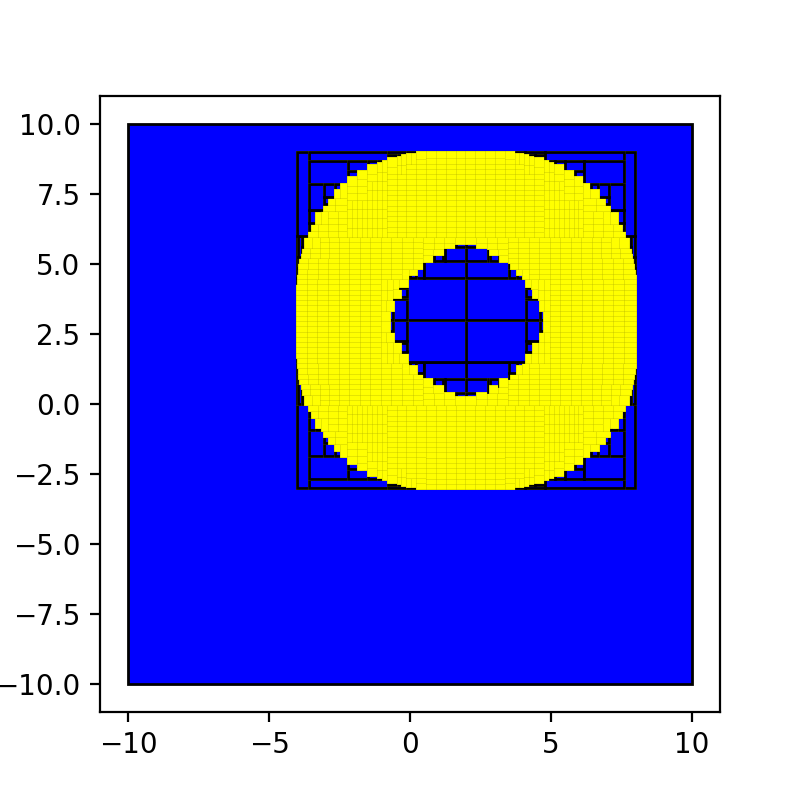

In [237]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))


cx = Interval(1, 3)
cy = Interval(2, 4)
r = Interval(4, 5)

X = Box(Interval(-10, 10), Interval(-10, 10))
sivia(X, eps=0.3, cx=cx, cy=cy, r=r)

# Separators 

Given a set $S$, a separator for $S$ is a pair of two contractors: one for $S$ and one for its complementary set $\bar{S}$. 

More precisely, for a given box [x], a separator $Sep$ for $S$ will return two subboxes [a] and [b] of [x] such that [a]∩S = [x]∩S and [b]∩S = [x]∩S.

The idea is shown in the Figure below.

![separator-1](pics/csp/separator-1.png)

The red contraction is done using the complement of set S (otherwise I cannot really contract it because it would be part of the solution).

## Programming a separator

Let's program a separator for the set:

$S_0 = \{(x,y) \in \mathcal{R}^2 | (x−c_x)^2 +(y−c_y)^2 \in [r]^2 \}􏰃.$

Note that this defines a ring. $c_x, c_y \in \mathcal{R}^2$, and $[r]$ is an interval.

Note that the part outside the outer ring can be defined using the interval: $[r_max, inf]$.

In [243]:
def s_ring(x, y, cx, cy, r, outer):
    # This separator only returns one box.
    # We need to call it twice, once as a contrator for S
    # and once as a contractor for \bar{S}
    # we use outer to output whether:
    # if outer = 1, normal contractor
    # if outer = 0, contractor on the complementary set
    if outer:
        return c_ring(x, y, cx, cy, r) # normal contractor
    else:
        # we contract with respect to the complementary set
        # In our case, the complementary set is composed of the inner disk and the outer space.
        # For this reason we use two boxes, one for each set
        xa, ya = x, y
        xb, yb = x, y        
        # Contraction with respect to the internal disk.
        # Note that we used Interval(-1, r.lo) to avoid the singularity in 0.
        # We could have written Interval(0, r.lo)
        xa, ya = c_ring(x, y, cx, cy, Interval(-1, r.lo)) 
        # Contraction with respect to the external disk.             
        xb, yb = c_ring(x, y, cx, cy, Interval(r.up, inf)) 
        # and we return the union of the two sets.
        x, y = xa | xb, ya | yb
        return x,y
            

In [247]:
def sivia(X: Box, eps: float, cx: Interval, cy: Interval, r: Interval):
    if X.width() < eps:
        return
    draw_box(X, facecolor='blue', edgecolor='black') # this is not a solution
    # contract
    X.x, X.y = s_ring(X.x, X.y, cx, cy, r, outer=True)
    draw_box(X, facecolor='magenta', edgecolor='black') # this is not a solution
    # contract the complement
    X.x, X.y = s_ring(X.x, X.y, cx, cy, r, outer=False)
    # we draw what remains yellow
    draw_box(X, facecolor='yellow', edgecolor='yellow') # this is uncertain (not solution, or solution)
    sivia(X.left(), eps, cx, cy, r)
    sivia(X.right(), eps, cx, cy, r)

<IPython.core.display.Javascript object>


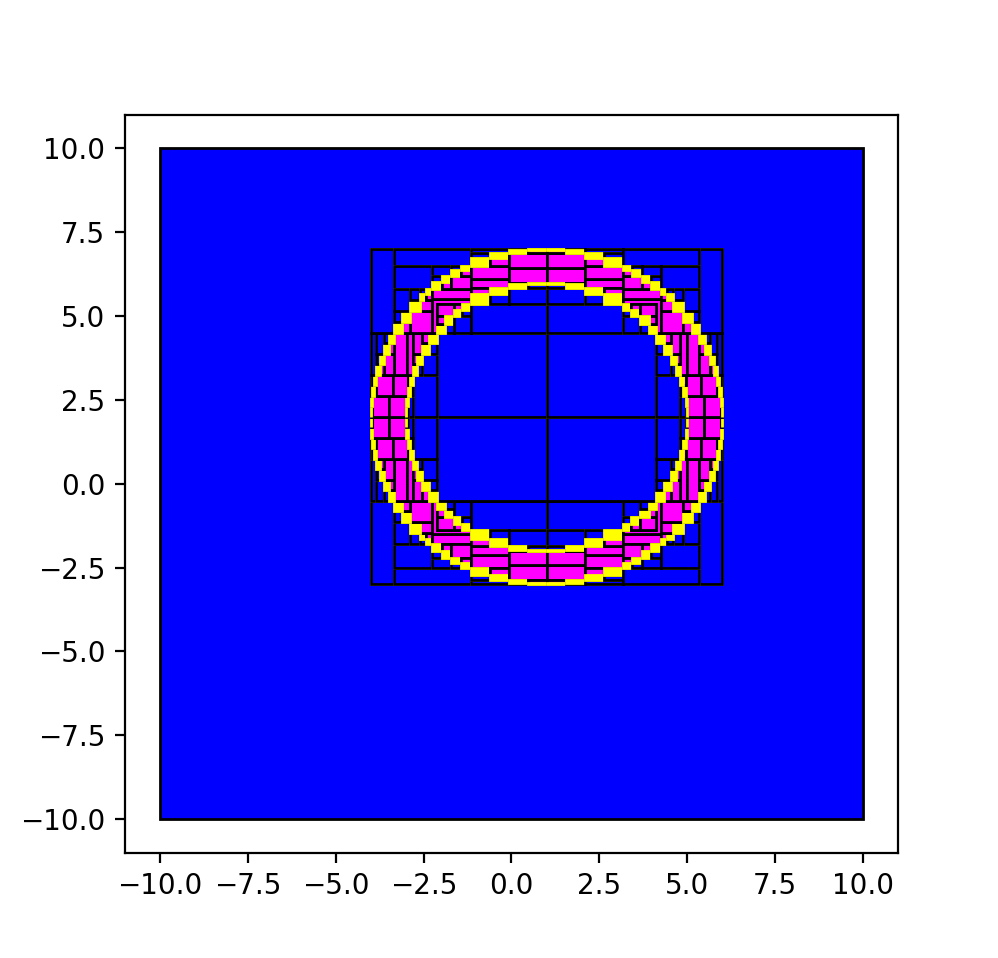

In [245]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))


cx = Interval(1, 1)
cy = Interval(2, 2)
r = Interval(4, 5)

X = Box(Interval(-10, 10), Interval(-10, 10))
sivia(X, eps=0.3, cx=cx, cy=cy, r=r)

The figure shows that we have an inner and an outer approximation

If we want to do the same but for the intersection/union between two sets, we need to calculate a contractor per each set and then do the intersection/union.

For separators we need to remember that the complement:
$\bar{S}=\overline{S_1 \cap S_2} = \overline{S}_1 \cup \overline{S}_2$ (De Morgan)

So to calculate a separator for the intersection of two sets:
- $S = S_1 \cap S_2$
- $\bar{S} = \overline{S}_1 \cup \overline{S}_2$

![intersection](pics/csp/intersection.png)


![intersection](pics/csp/union.png)

Let's now use the previous separator to calculate:

$S = S_1 \cap S_2$ where the two sets $S_1, S_2$ have different parameters

In [248]:
def sep(x, y, outer):
    cx_1, cy_1 = Interval(1, 1), Interval(2, 2)
    r_1 = Interval(4, 5)
    
    cx_2, cy_2 = Interval(2, 2), Interval(5, 5)
    r_2 = Interval(5, 6)

    # remember that we need two boxes (one per set)
    x1, y1 = x, y
    x2, y2 = x, y   
    x1, y1 = s_ring(x1, y1, cx_1, cy_1, r_1, outer)
    x2, y2 = s_ring(x2, y2, cx_2, cy_2, r_2, outer)
    
    if outer:
        x, y = x1&x2, y1&y2
    else:
        x, y = x1|x2, y1|y2
        
    return x, y

In [251]:
def sivia(X: Box, eps: float):
    if X.width() < eps:
        return
    draw_box(X, facecolor='blue', edgecolor='black') # this is not a solution
    # contract
    X.x, X.y = sep(X.x, X.y, outer=True)
    draw_box(X, facecolor='magenta', edgecolor='black') # this is not a solution
    # contract the complement
    X.x, X.y = sep(X.x, X.y, outer=False)
    # we draw what remains yellow
    draw_box(X, facecolor='yellow', edgecolor='yellow') # this is uncertain (not solution, or solution)
    sivia(X.left(), eps)
    sivia(X.right(), eps)

<IPython.core.display.Javascript object>


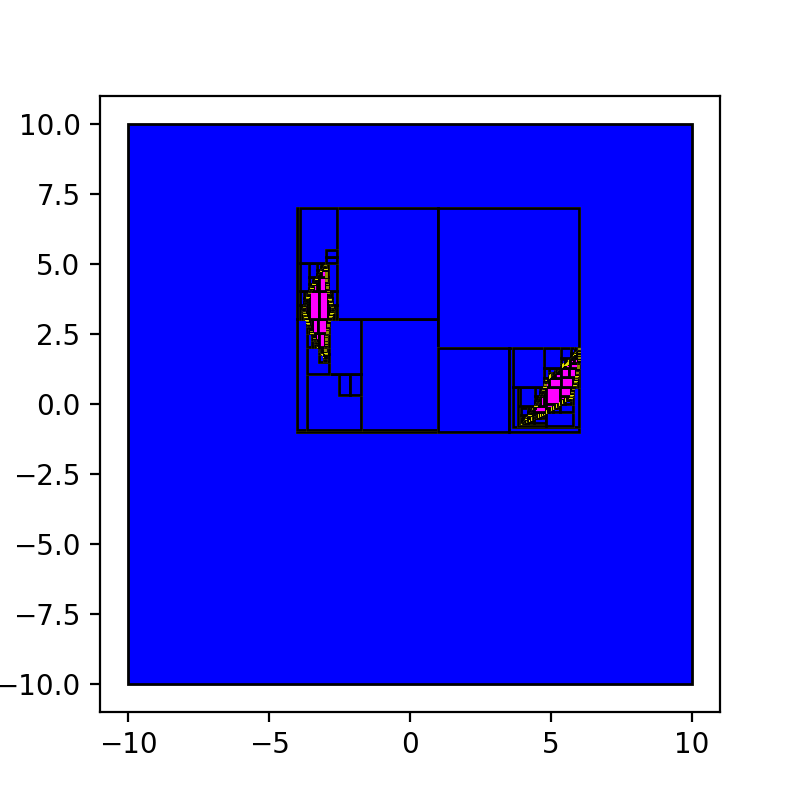

In [254]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))


cx_1 = Interval(1, 1)
cy_1 = Interval(2, 2)
r_1 = Interval(4, 5)

X = Box(Interval(-10, 10), Interval(-10, 10))
sivia(X, eps=0.01)

And we obtain the intersection between the two rings.

If insted we want to calculate the union of the two sets, we only need to change the separator a bit (using again the De Morgan rule):



In [255]:
def sep_u(x, y, outer):
    cx_1, cy_1 = Interval(1, 1), Interval(2, 2)
    r_1 = Interval(4, 5)
    
    cx_2, cy_2 = Interval(2, 2), Interval(5, 5)
    r_2 = Interval(5, 6)

    # remember that we need two boxes (one per set)
    x1, y1 = x, y
    x2, y2 = x, y   
    x1, y1 = s_ring(x1, y1, cx_1, cy_1, r_1, outer)
    x2, y2 = s_ring(x2, y2, cx_2, cy_2, r_2, outer)
    
    if outer:
        x, y = x1|x2, y1|y2
    else:
        x, y = x1&x2, y1&y2
        
    return x, y

In [258]:
def sivia(X: Box, eps: float):
    if X.width() < eps:
        return
    draw_box(X, facecolor='blue', edgecolor='black') # this is not a solution
    # contract
    X.x, X.y = sep_u(X.x, X.y, outer=True)
    draw_box(X, facecolor='magenta', edgecolor='black') # this is not a solution
    # contract the complement
    X.x, X.y = sep_u(X.x, X.y, outer=False)
    # we draw what remains yellow
    draw_box(X, facecolor='yellow', edgecolor='yellow') # this is uncertain (not solution, or solution)
    sivia(X.left(), eps)
    sivia(X.right(), eps)

<IPython.core.display.Javascript object>


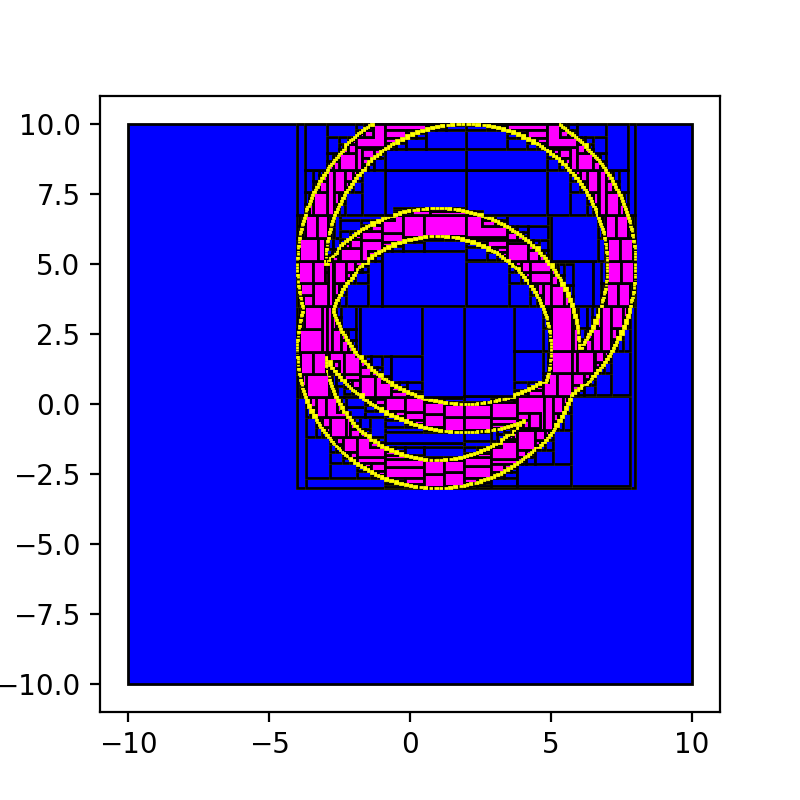

In [259]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))


cx_1 = Interval(1, 1)
cy_1 = Interval(2, 2)
r_1 = Interval(4, 5)


X = Box(Interval(-10, 10), Interval(-10, 10))
sivia(X, eps=0.1)

--------------

# Self-Localisation and Mapping using Interval Methods

We now consider the problem of self localization and mapping inside an environment with landmarks. 

**We now also switch to pybex to solve the problems.**

$S_0 = 􏰂(x,y) \in \mathcal{R}^2 | \exists (cx, cy) \in [1,3]×[2,4], (x−cx)^2+(y−cy)^2 \in [2,4]^2􏰃 $

This is similar to what we have done in c_ring(x, y, cx, cy, r), section [Forward-backward contractors](#Forward-backward-contractors) and implemented in [Example: forward-backward contractors](#Example:-forward-backward-contractors)

We only had an outer approx because we only used a contractor and not a separator.

In [187]:
from pyibex import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

**We now change the function `draw_box` to use pyibex output**

<IPython.core.display.Javascript object>


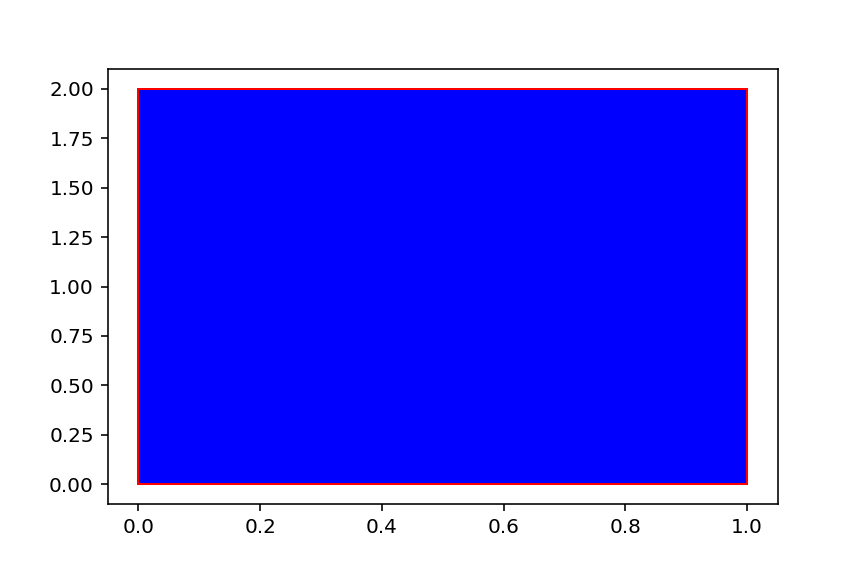

In [186]:
# Create figure and axes
def _draw_box(x_lo, x_up, y_lo, y_up, edgecolor='black', facecolor='blue', ax=None):
    if ax is None: ax = plt.gca()        
    xy = (x_lo,y_lo)    
    width  = x_up-x_lo
    height = y_up-y_lo
    # Create a Rectangle patch
    rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor=edgecolor,facecolor=facecolor)
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.autoscale()
    return ax

def draw_box(b, edgecolor='black', facecolor='blue', ax=None):
    b_lo, b_up = b.lb(), b.ub()
    return _draw_box(b_lo[0], b_up[0], b_lo[1], b_up[1], edgecolor, facecolor, ax)

fig, ax = plt.subplots(1)
_draw_box(0, 1, 0, 2, 'red');

In [183]:
class Contractor(Ctc):
    def __init__(self, cx, cy, r):
        Ctc.__init__(self, 2) # init Ctc abstract class, # 2 is the dimention of the box I want to contract
        self.cx, self.cy, self.r = cx.copy(), cy.copy(), r.copy()
        
    def contract(self, box):
        """Modifies the box 'box' and contract it.
        We do that relying on the fact that we use references."""
        # extract the intervals from the 2D box
        x, y = box[0], box[1] # we use references here.
        # set parameters as defined in the problem
        cx, cy, r = self.cx.copy(), self.cy.copy(), self.r.copy()
                    
        # and now we define the constraints and the forward contractors
        a, b = x - cx, y - cy
        a2, b2, r2 = sqr(a),sqr(b),sqr(r)
        # backward part
        bwd_add(r2, a2, b2) # back prop associated to r2 = a2+b2 (which it is not need to have as a forward)
        # back prop associated to a2, b2 = sqr(a),sqr(b)
        bwd_sqr(a2, a)
        bwd_sqr(b2, b) 
        # back prop associated to a = x - cx, b = y - cy
        bwd_sub(a, x, cx)
        bwd_sub(b, y, cy) 
        
        # before we add these contractors:
        # forward:
        # r2, a2, b2 = c_add(r2, a2, b2)
        # a2, a = c_sqr(a2, a)
        # b2, b = c_sqr(b2, b)    
        # r does not need to be contracted.
        # and backward:
        # y, b, cy = c_add(y, b, cy)
        # x, a, cx = c_add(x, a, cx)
    


In [184]:
X = IntervalVector(2, [-10, 10]) # corresponds to X = Box(Interval(-10, 10), Interval(-10, 10))

contractor = Contractor(Interval(1, 3), Interval(2, 4), Interval(4, 5))

out_boxes, in_boxes = pySIVIA(X, contractor, epsilon=0.5, draw_boxes=False) 

number of contraction 1657 / number of boxes 969


<IPython.core.display.Javascript object>


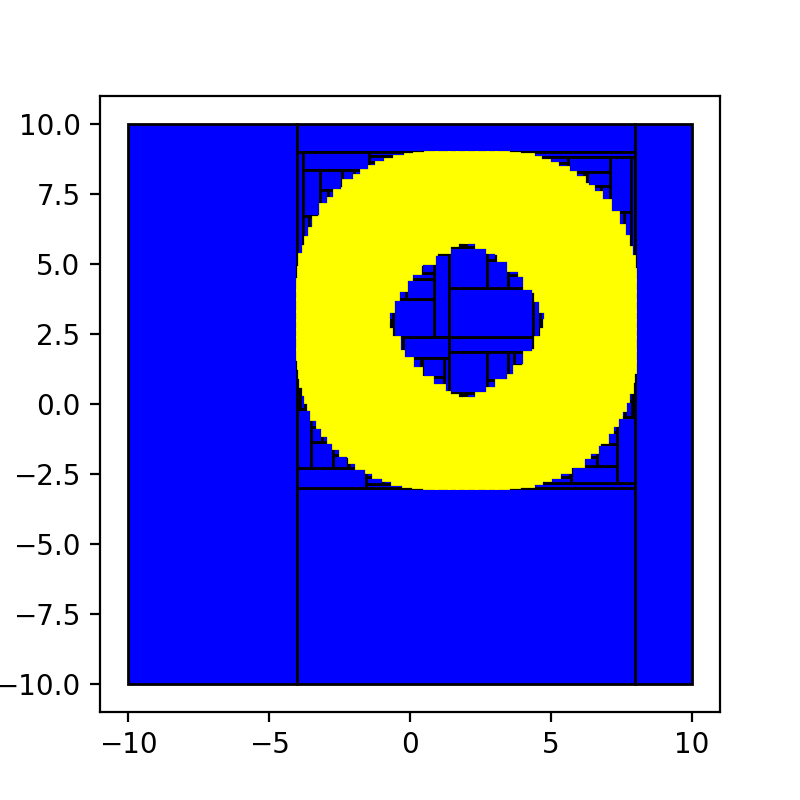

In [186]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

### Contractors in pyibex

All the previous code can be replaced by the Function object in pyibex:

In [199]:
X = IntervalVector([[-10, 10], [-10, 10]]) # corresponds to X = Box(Interval(-10, 10), Interval(-10, 10))

r = Interval(4, 5)

f = Function("x1", "x2", "(x1-[1,3])^2 + (x2-[2,4])^2")
 
contractor = CtcFwdBwd(f, sqr(r))

out_boxes, in_boxes = pySIVIA(X, contractor, epsilon=0.5, draw_boxes=False) 

number of contraction 1657 / number of boxes 969


<IPython.core.display.Javascript object>


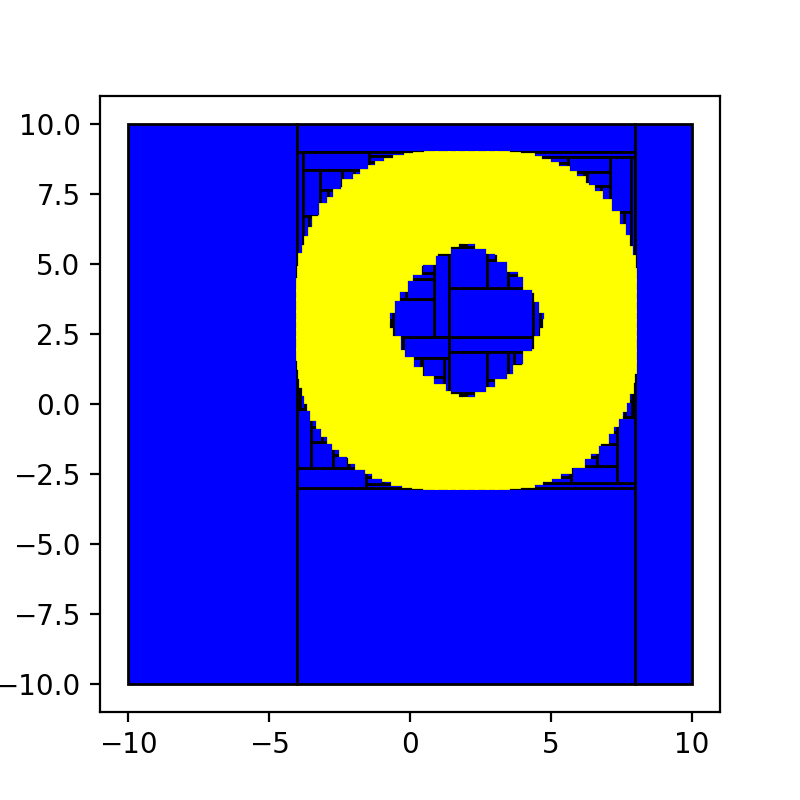

In [200]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

### Separators in pyibex

In [220]:
X = IntervalVector([[-10, 10], [-10, 10]]) # corresponds to X = Box(Interval(-10, 10), Interval(-10, 10))

r = Interval(4, 5)

f = Function("x1", "x2", "(x1-[1,3])^2 + (x2-[2,4])^2")
 
separator = SepFwdBwd(f, sqr(r))

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.5, draw_boxes=False) 

number of separation 1657 / number of boxes 969


<IPython.core.display.Javascript object>


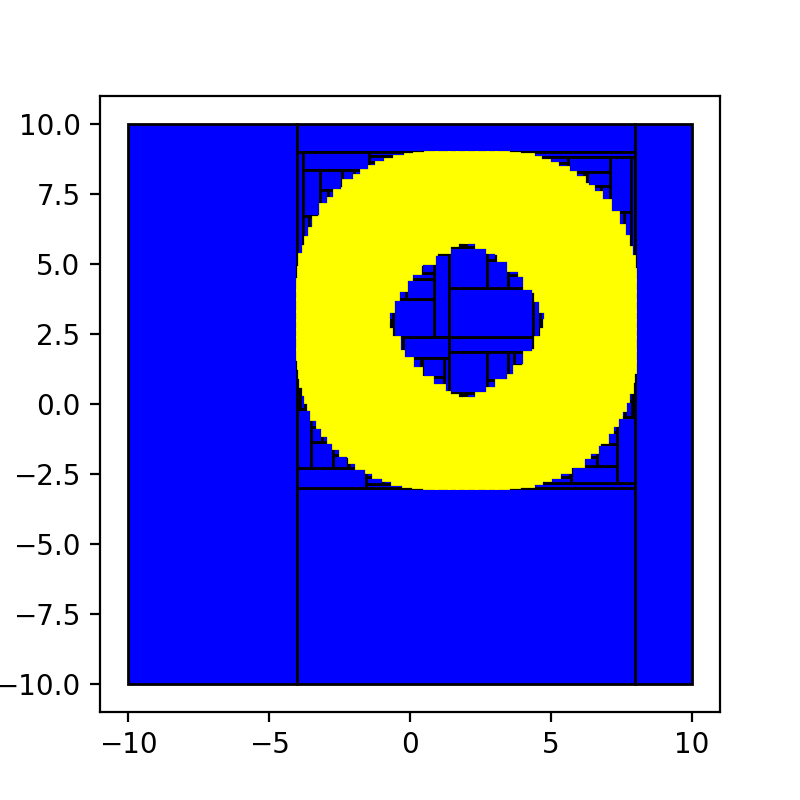

out_boxes
in_boxes
maybe_boxes


In [221]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

print('out_boxes')
for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
print('in_boxes')    
for b in in_boxes:
    draw_box(b, edgecolor='black', facecolor='red', ax=ax)
    
print('maybe_boxes')
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

Depending on the interval accuracy the paver is able to find an inner and outer approaximation. In the previous case, for example, where all our intervals were quite big it was not possible. If instead we reduce them:

In [212]:
X = IntervalVector([[-10, 10], [-10, 10]]) # corresponds to X = Box(Interval(-10, 10), Interval(-10, 10))

r = Interval(4, 5)

f = Function("x1", "x2", "(x1-[1,1.3])^2 + (x2-[2,2.3])^2")
 
separator = SepFwdBwd(f, sqr(r))

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.2, draw_boxes=False) 

number of separation 2551 / number of boxes 2047


<IPython.core.display.Javascript object>


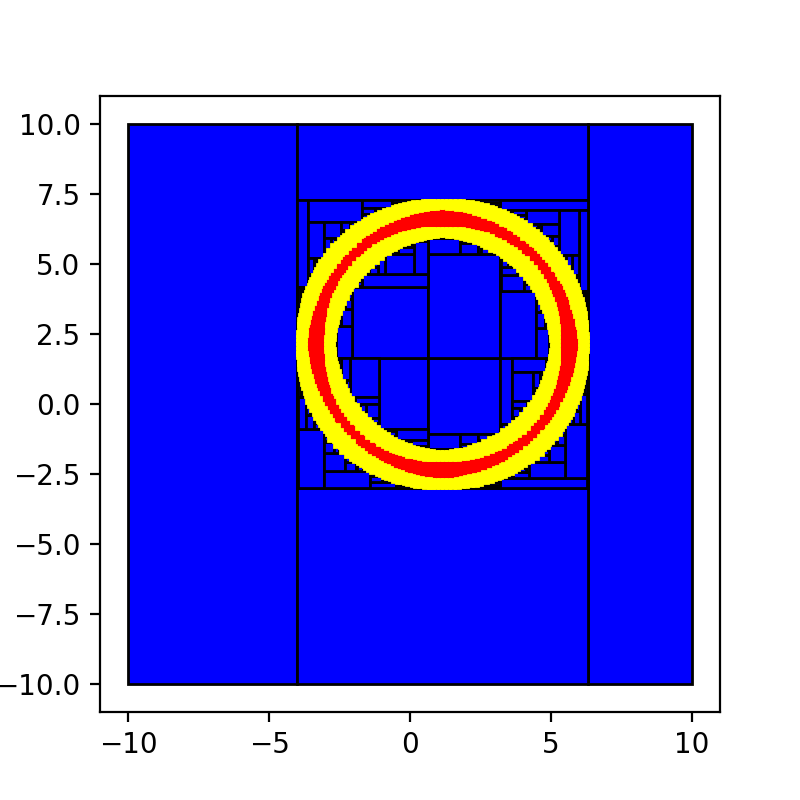

In [213]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

Where the thikness of the yellow area depends on the size of the intervals.
Try, for example what happens when:
     
     f = Function("x1", "x2", "(x1-[1,1.0])^2 + (x2-[2,2.0])^2")

### Intersections and unions of separators using pyibex

One of the main advantages of using pyibex is that it allows to build contractors and separators very easily using the contractor algebra.
In the examples below we implement the same separators that we implemented from scratch already but this time we use pyibex.

In [214]:
X = IntervalVector([[-10, 10], [-10, 10]]) # corresponds to X = Box(Interval(-10, 10), Interval(-10, 10))

r_1 = Interval(4, 5)
r_2 = Interval(5, 6)

# note that we are now using the vector notation
f_1 = Function("x[2]", "(x[0]-1)^2 + (x[1]-2)^2")
f_2 = Function("x[2]", "(x[0]-2)^2 + (x[1]-5)^2") 

separator_1 = SepFwdBwd(f_1, sqr(r_1))
separator_2 = SepFwdBwd(f_2, sqr(r_2))

separator = separator_1 & separator_2

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.2, draw_boxes=False) 

number of separation 193 / number of boxes 317


<IPython.core.display.Javascript object>


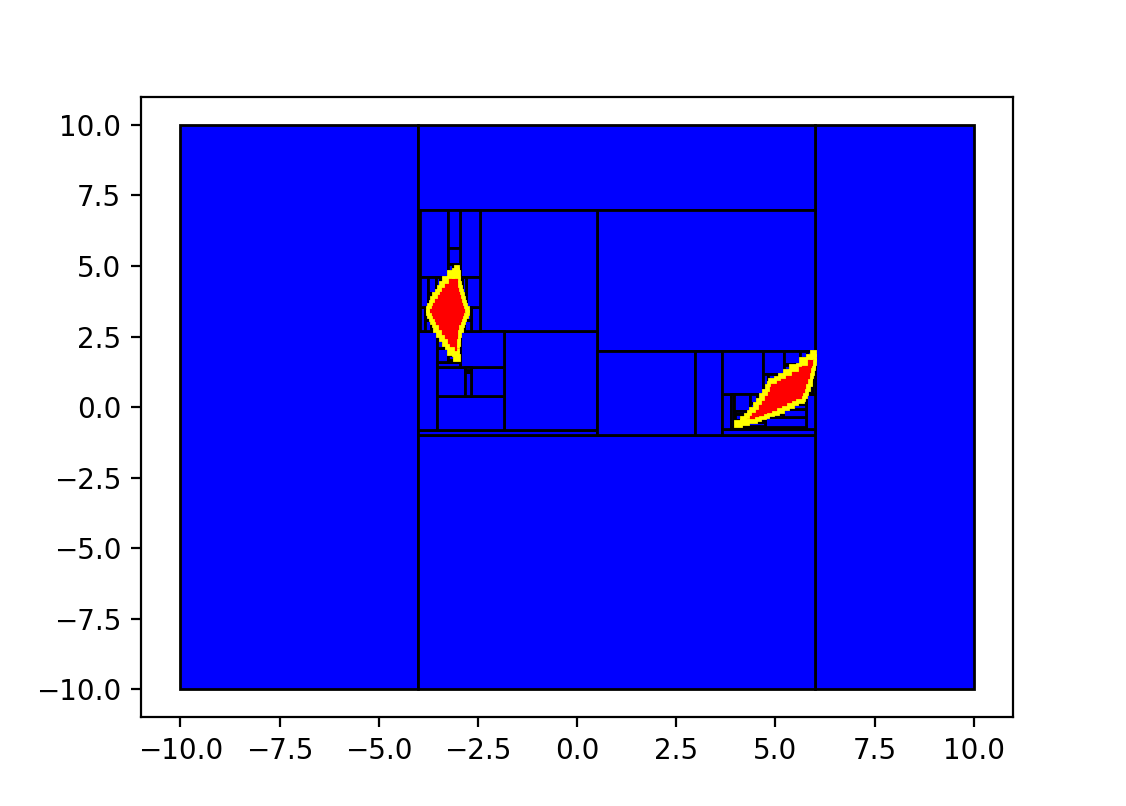

In [215]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

In [216]:
X = IntervalVector([[-10, 10], [-10, 10]]) # corresponds to X = Box(Interval(-10, 10), Interval(-10, 10))

r_1 = Interval(4, 5)
r_2 = Interval(5, 6)

# note that we are now using the vector notation
f_1 = Function("x[2]", "(x[0]-1)^2 + (x[1]-2)^2")
f_2 = Function("x[2]", "(x[0]-2)^2 + (x[1]-5)^2") 

separator_1 = SepFwdBwd(f_1, sqr(r_1))
separator_2 = SepFwdBwd(f_2, sqr(r_2))

separator = separator_1 | separator_2

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.2, draw_boxes=False) 

number of separation 1323 / number of boxes 1999


<IPython.core.display.Javascript object>


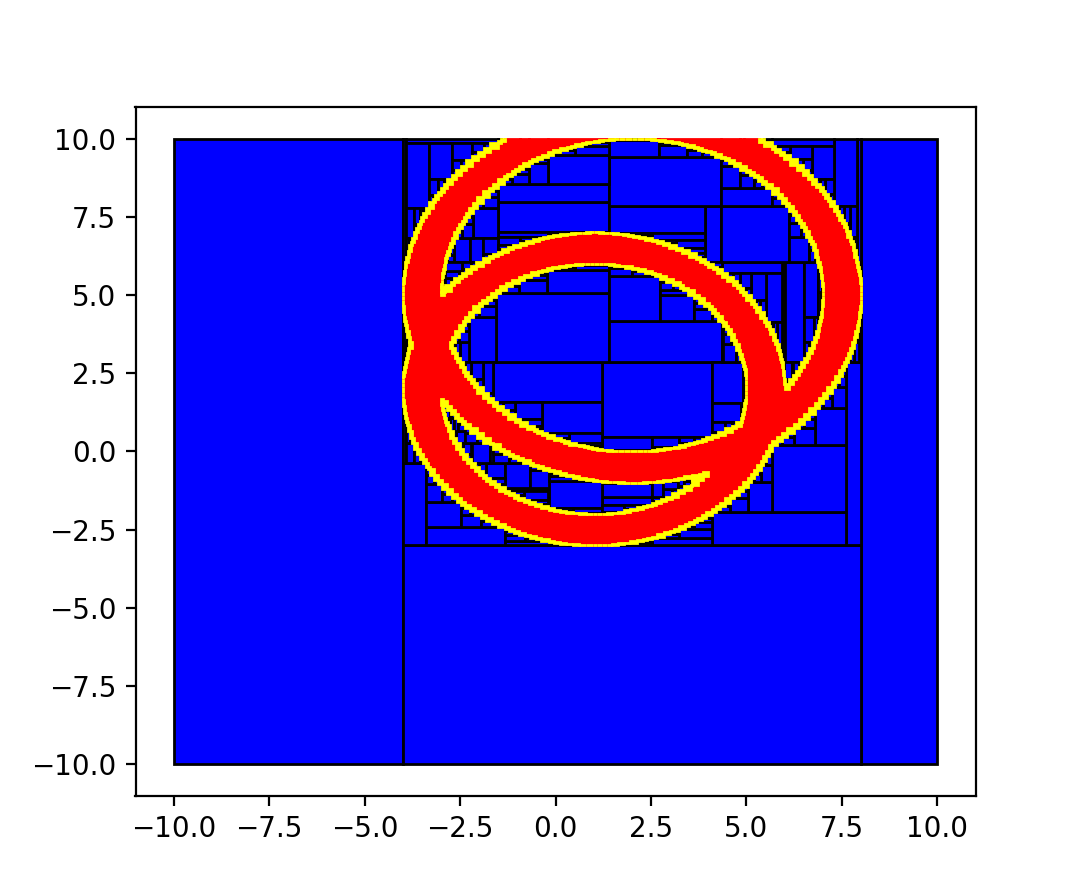

In [217]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

# Parameter estimation using pyibex 

Recall, our problem.

Assumption: all errors are bounded.

Suppose you have a model:

$y(t) = p_1exp^{-p_2t}$

and some measurements:

y(t_1=0.2) =  $[1.5, 2]$  
y(t_2=1) =  $[0.7, 0.8]$  
y(t_3=2) =  $[0.1, 0.3]$  
y(t_4=4) =  $[-0.1, 0.03]$  

where $[-n_i, n_i]$ is the noise interval with which I can measure the variables.

Prior box $X_0 = [-3, 3] x [-3, 3]$

In [224]:
# initial domain
X = IntervalVector([[-3,3], [-3, 3]])

# time
T = [0.2, 1, 2, 4] 

# measurements
Y = [Interval(1.5, 2), 
     Interval(0.7, 0.8), 
     Interval(0.1, 0.3), 
     Interval(-0.1, 0.03)] 

If we only consider one constraint, we obtain the set of (p1, p2) that  satisfy that single constraint

In [236]:
t = T[0]
y = Y[0]

print(f't: {t}')
print(f'y: {y}')

# note that we are now using the vector notation
f_1 = Function("p[2]", "p[0]*exp(p[1]*%f)" % t)
separator_1 = SepFwdBwd(f_1, y)

#separator = separator_1 & separator_2

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator_1, epsilon=0.2, draw_boxes=False) 

t: 0.2
y: [1.5, 2]
number of separation 177 / number of boxes 267


<IPython.core.display.Javascript object>


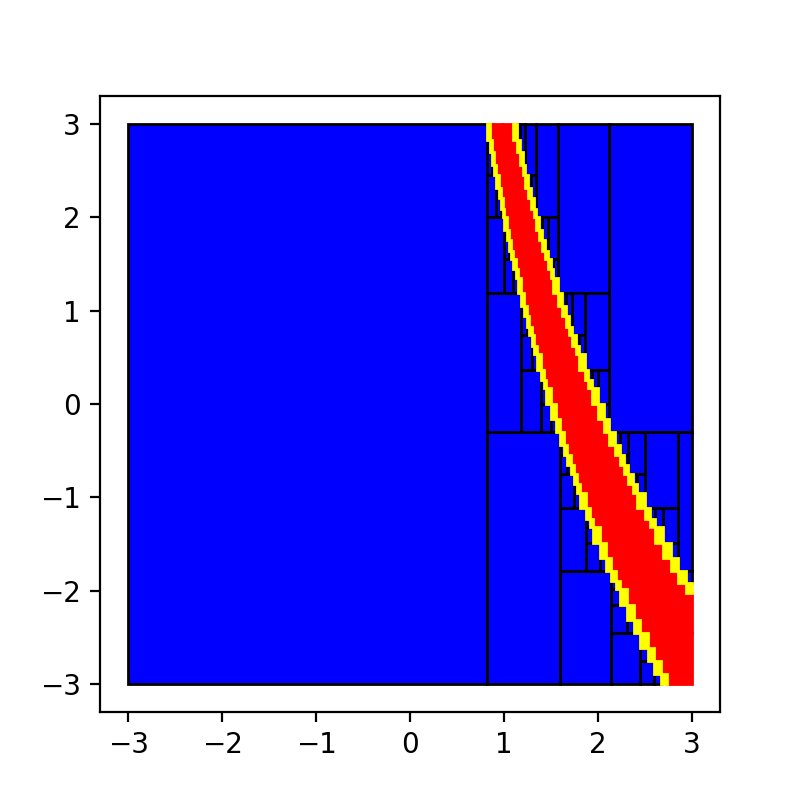

In [237]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

We can do it for the second constraint only

In [244]:
t = T[1]
y = Y[1]

print(f't: {t}')
print(f'y: {y}')

# note that we are now using the vector notation
f_1 = Function("p[2]", "p[0]*exp(p[1]*%f)" % t)
separator_1 = SepFwdBwd(f_1, y)

#separator = separator_1 & separator_2

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator_1, epsilon=0.05, draw_boxes=False) 

t: 1
y: [0.7, 0.8]
number of separation 493 / number of boxes 741


<IPython.core.display.Javascript object>


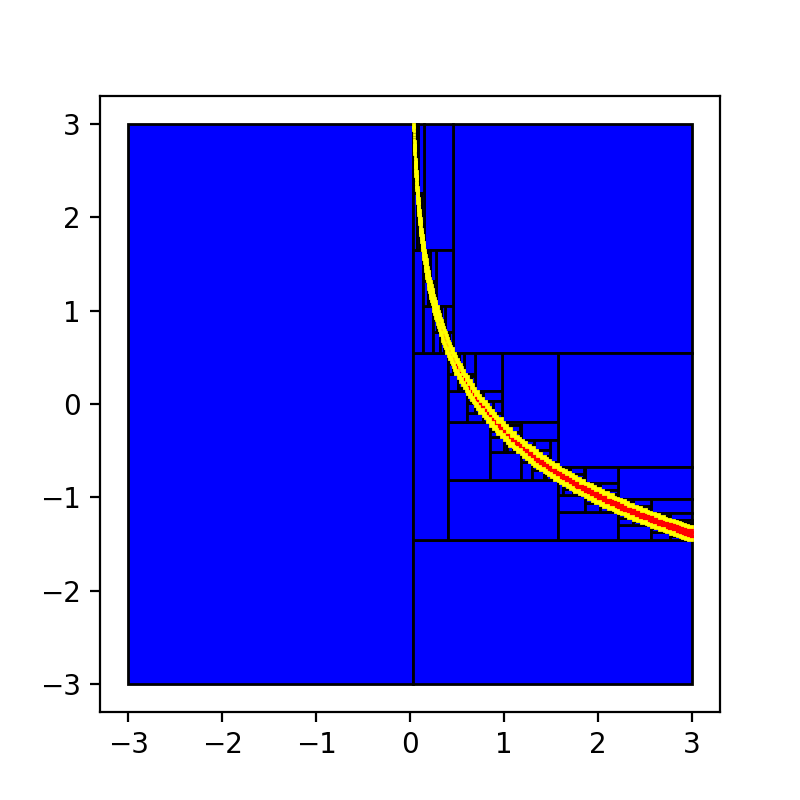

In [245]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

We can now add together all the constraints, which corresponds to do their intersections:

In [253]:
separator = None

for t, y in zip(T, Y):
    print(f't: {t}, y: {y}')
    # note that we are now using the vector notation
    f_1 = Function("p[2]", "p[0]*exp(p[1]*%f)" % t)
    separator_1 = SepFwdBwd(f_1, y)
    if separator == None:
        separator = separator_1
    else:
        separator = separator & separator_1

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.05, draw_boxes=False) 

t: 0.2, y: [1.5, 2]
t: 1, y: [0.7, 0.8]
t: 2, y: [0.1, 0.3]
t: 4, y: [-0.1, 0.03]
number of separation 65 / number of boxes 120


<IPython.core.display.Javascript object>


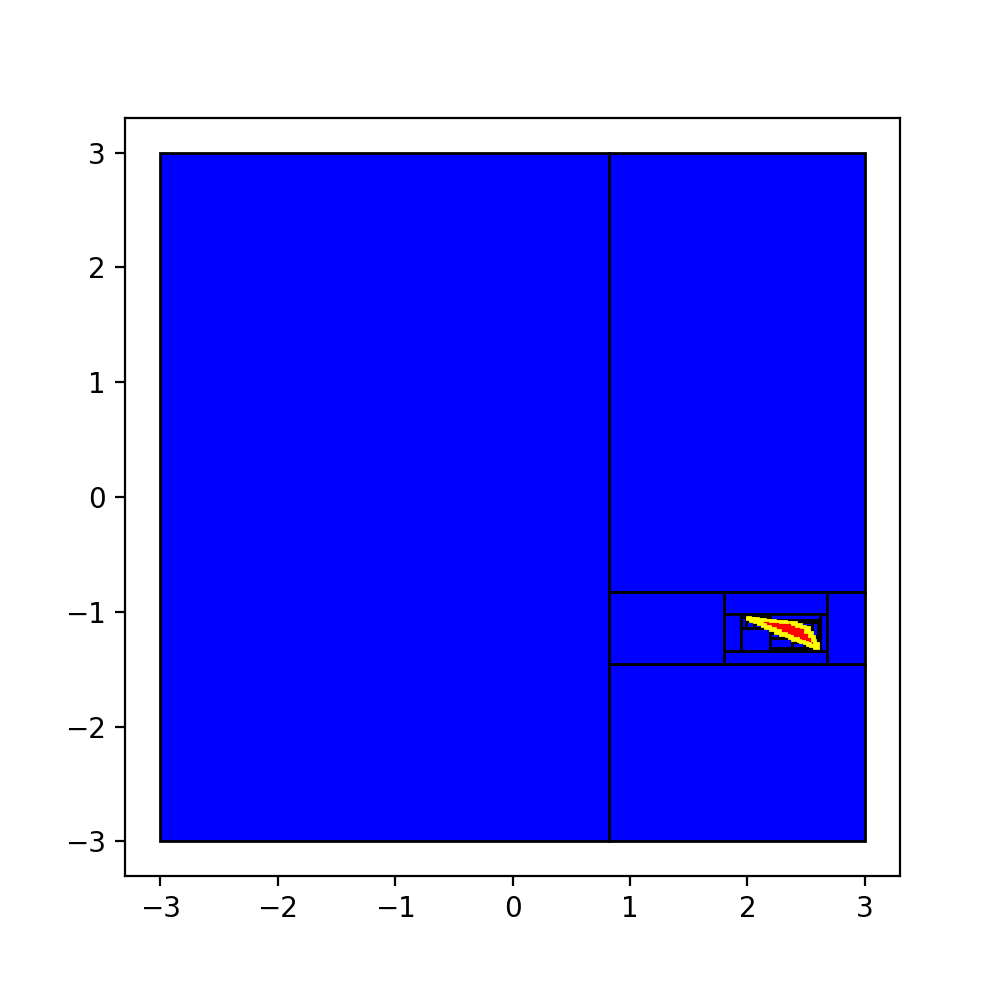

In [254]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

This set is very similar to one we obtained before when we used inclusion tests instead of contractors or separators.

## Q-relaxed intersection using pyibex

Allows to tackle outliers where some parameter sets do not intersect with the others.

In this case, 1-relaxed intersection means that one parameter is allowed to be outside of the intersection region.

See figure below:

![1-relaxed-intersection](pics/csp/1-relaxed-intersection.png)

If we need to relax two sets, this corresponds to the 2-relaxed intersection, etc.

![3-relaxed-intersection](pics/csp/3-relaxed-intersection.png)

Above is the 3-relaxed intersection and below the 4-relaxed intersection

![4-relaxed-intersection](pics/csp/4-relaxed-intersection.png)

To implement the q-relaxed intersection we can use `SepQInterProjF` in pyibex.
You can play with the parameter `qrelaxed_separator.q` to change the number of relaxed sets.

In [263]:
separators = []

for t, y in zip(T, Y):
    print(f't: {t}, y: {y}')
    # note that we are now using the vector notation
    f_1 = Function("p[2]", "p[0]*exp(p[1]*%f)" % t)
    separator = SepFwdBwd(f_1, y)
    separators.append(separator)
    
# we want now to do the relaxed intersection    
qrelaxed_separator = SepQInterProjF(separators)    
qrelaxed_separator.q = 2 # number of set to relax

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, qrelaxed_separator, epsilon=0.05, draw_boxes=False) 

t: 0.2, y: [1.5, 2]
t: 1, y: [0.7, 0.8]
t: 2, y: [0.1, 0.3]
t: 4, y: [-0.1, 0.03]
number of separation 437 / number of boxes 677


<IPython.core.display.Javascript object>


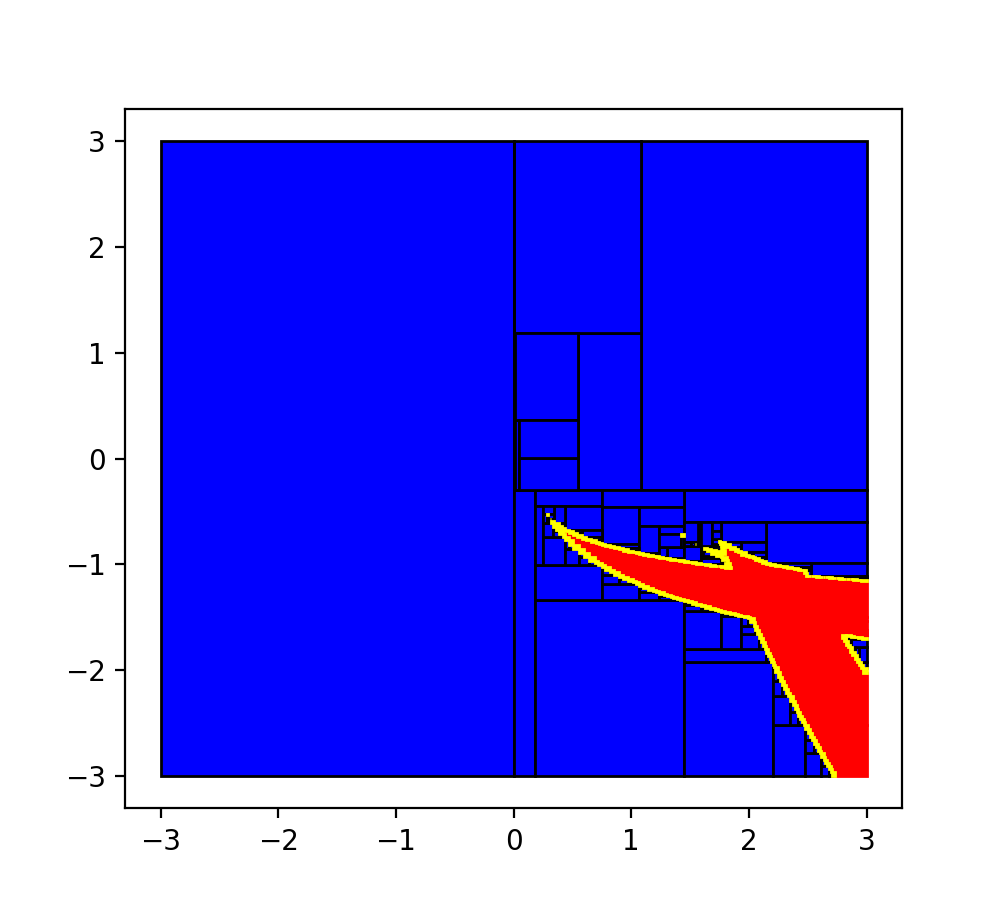

In [264]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

And again it is similar to what we obtained before using inclusion tests only and with the library that we built from scratch.

# Identify outliers using the GOMNE method

GOMNE means Guaranteed Outlier Minimal Number Estimator.  
This method calculates the smalles `q` such that the relaxed intersection is not empty.

Let's add some outliers first to our problem:

In [266]:
# initial domain
X = IntervalVector([[-3,3], [-3, 3]])

# time
T = [0.2, 1, 2, 4, 5, 6, 7] 

# measurements
Y = [Interval(1.5, 2), 
     Interval(0.7, 0.8), 
     Interval(0.1, 0.3), 
     Interval(0.0, 1.0),
     Interval(1.0, 2.0), # outlier
     Interval(1.0, 2.0)  # outlier
    ] 

Given that we have outliers, if we run the code below with `q=0` (or `q=1`) we would obtain the empty set: in_boxes=[], maybe_boxes=[].

We need to run with `q=2` to have a solution.

In [275]:
separators = []

for t, y in zip(T, Y):
    print(f't: {t}, y: {y}')
    # note that we are now using the vector notation
    f_1 = Function("p[2]", "p[0]*exp(p[1]*%f)" % t)
    separator = SepFwdBwd(f_1, y)
    separators.append(separator)
    
# we want now to do the relaxed intersection    
qrelaxed_separator = SepQInterProjF(separators)    
qrelaxed_separator.q = 2 # number of set to relax

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, qrelaxed_separator, epsilon=0.05, draw_boxes=False) 

t: 0.2, y: [1.5, 2]
t: 1, y: [0.7, 0.8]
t: 2, y: [0.1, 0.3]
t: 4, y: [0, 1]
t: 5, y: [1, 2]
t: 6, y: [1, 2]
number of separation 157 / number of boxes 261


In [276]:
# in_boxes, out_boxes, maybe_boxes

<IPython.core.display.Javascript object>


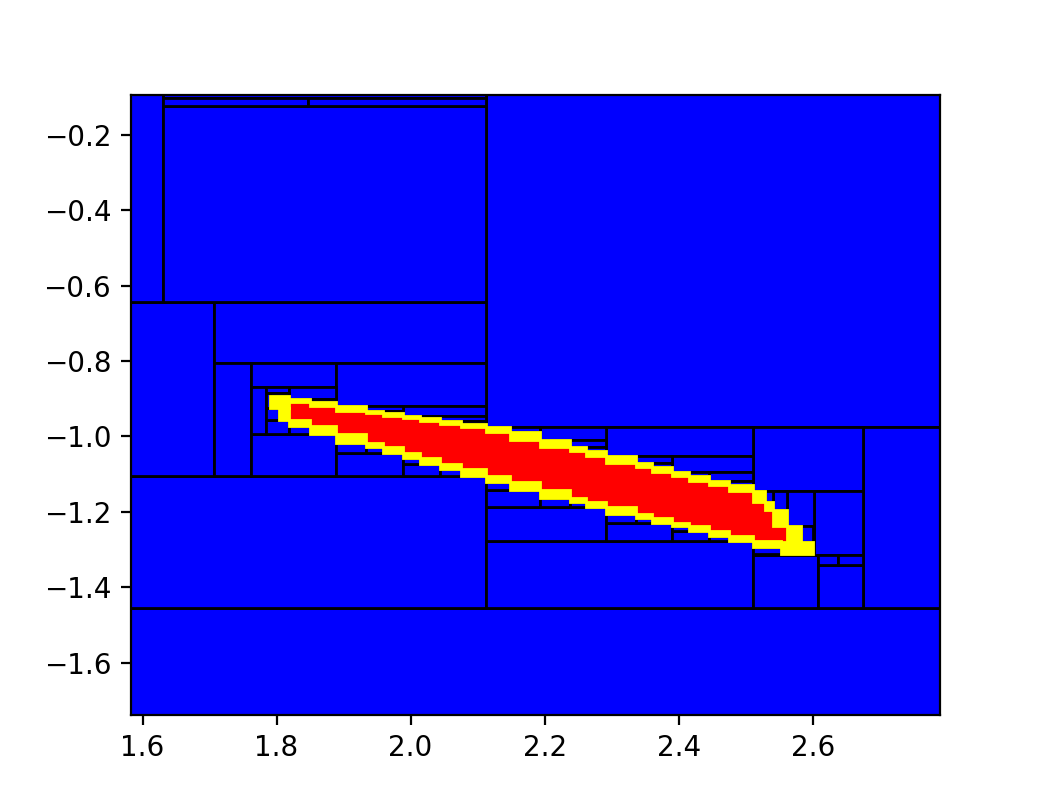

In [277]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)

The GOMNE method checks if a measuremnet is an outlier taking the intersection with a feasible set.

For example to check if a measurement is an outlier:

In [284]:
separators = []

for t, y in zip(T, Y):
    print(f't: {t}, y: {y}')
    # note that we are now using the vector notation
    f_1 = Function("p[2]", "p[0]*exp(p[1]*%f)" % t)
    separator = SepFwdBwd(f_1, y)
    separators.append(separator)
    
# we want now to do the relaxed intersection    
qrelaxed_separator = SepQInterProjF(separators)    
qrelaxed_separator.q = 2 # number of set to relax


t_f = T[-1]
y_f = Y[-1]
f = Function("p[2]", "p[0]*exp(p[1]*%f)" % t_f)
separator_j = SepFwdBwd(f, y_f)

qrelaxed_separator = qrelaxed_separator & separator_j

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, qrelaxed_separator, epsilon=0.05, draw_boxes=False) 

if len(in_boxes) == 0:
    print('>> Outlier detected.')
else:
    print('>> Outlier NOT detected')

t: 0.2, y: [1.5, 2]
t: 1, y: [0.7, 0.8]
t: 2, y: [0.1, 0.3]
t: 4, y: [0, 1]
t: 5, y: [1, 2]
t: 6, y: [1, 2]
number of separation 27 / number of boxes 72
>> Outlier detected.


#  Localization of a robot from landmarks using range and bearing measurements  

A robot has to localize inside an environment made of 4 landmarks $m(i)$ , $i \in \{1, . . . , 4\}$. It is able to measure its distance d (i) and the azimuth (angle between the robot and the landmark) $\alpha(i)$ corresponding to each landmark with some bounded errors. The coordinates of landmarks and the interval measurements are given in the following table:


| i| m(i) | $[d](i)$ | $[\alpha](i)$ |
|--|--|--|--|
|1| (6,12)|$[10, 13]$ | $[0.5, 1]$  |
|2| (-2, -5)| $[8, 10]$| $[-3, -3/2]$ |
|3| (-3, 20)| $[5, 7]$| $[1, 2]$ |
|4| (3, 4)| $[6, 8]$ | $[2, 3]$ | 


The set of all positions $p \in \mathcal{R}^2$ for the robot that are consistent with the i-th measurements is
$P_i = \{ 􏰂(p_1, p_2) \in \mathcal{R}^2 : \exists d \in [d](i)$, $\exists \alpha \in [\alpha](i)$ s.t. $m_1(i) = p1 + dcos\alpha$ and $m_2(i) = p_2 + d sin\alpha$ \}.

The idea is shown in the picture below:

![robot-localization](pics/csp/robot-localization.png)

In [381]:
landmarks = [[6,12], [-2, -5], [-3,20], [3,4]]

ds = [Interval(10,13),Interval(8,10),Interval(5,7),Interval(6,8)]

alphas = [Interval(0.5,1),Interval(-3,-3/2),Interval(1,2),Interval(2,3)]

<IPython.core.display.Javascript object>


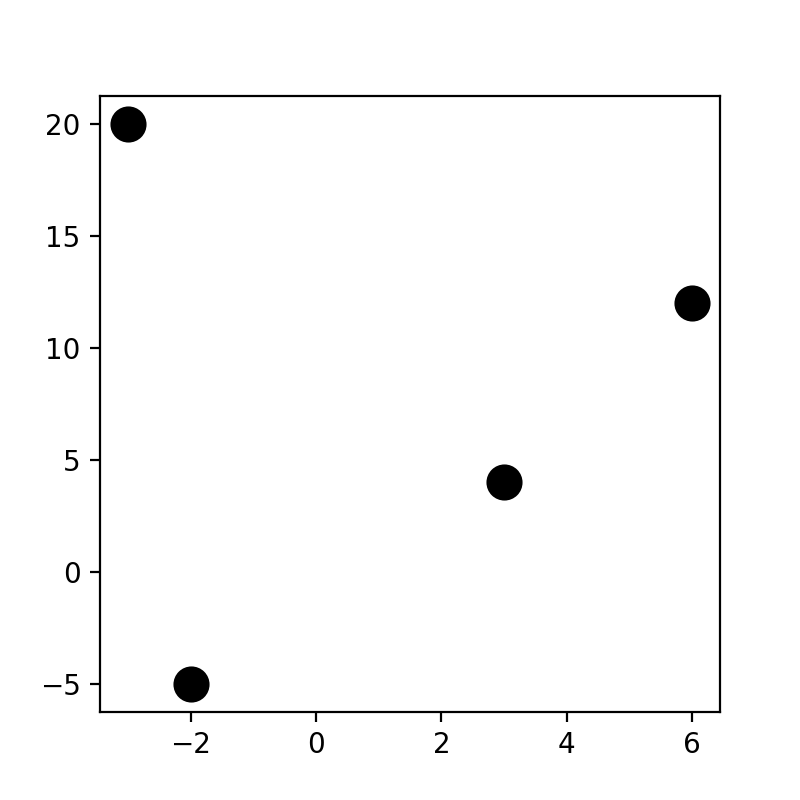

In [382]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

# draw the environment
for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
ax.autoscale()

In [383]:
from pyibex.geometry import SepPolarXY

Let's first draw one of the measurement sets. Note that this will not correpond to anything - it is just a set for now.

In [384]:
separator = SepPolarXY(ds[0], alphas[0])

X = IntervalVector([[-20, 20],[-20, 20]])

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.1, draw_boxes=False) 

number of separation 395 / number of boxes 610


<IPython.core.display.Javascript object>


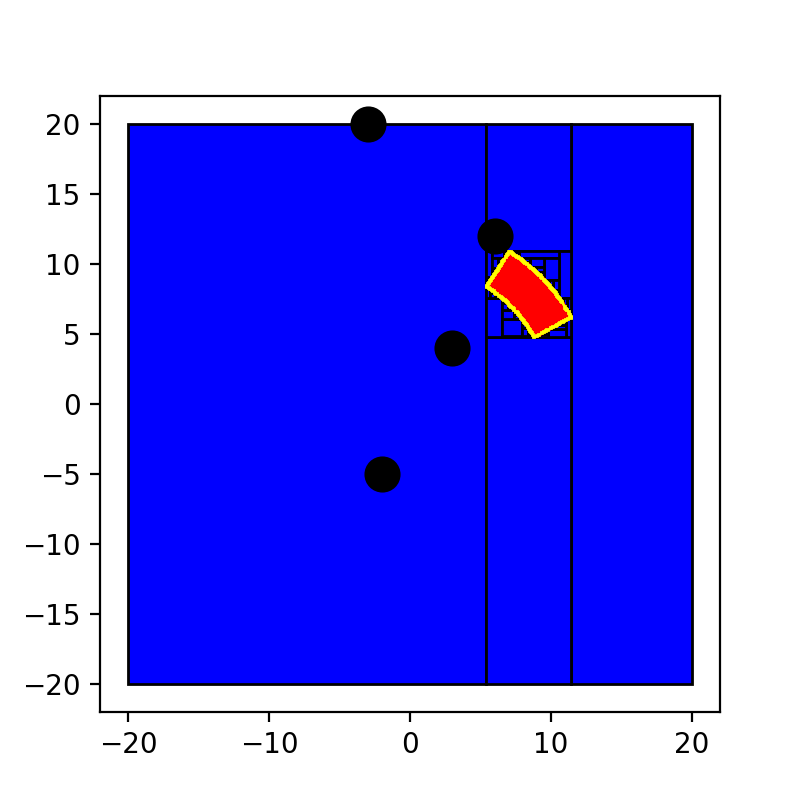

In [385]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
    
# draw the environment
for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
ax.autoscale()

## Geometrical transformations of separators

Let's define a function first:

In [386]:
# we define a rotation matrix and set p1, p2 as the position of the robot.
f = Function('p1', 'p2', '(cos(1)*p1 - sin(1)*p2; sin(1)*p1 + cos(1)*p2)')

# and we also need to define the inverse of f1.
# In this case, we just need to transpose the rotation matrix.
f_inv = Function('p1', 'p2', '(cos(1)*p1 + sin(1)*p2; -sin(1)*p1 + cos(1)*p2)')

In [387]:
# the new separator is rotated by -1 rad.
separator_rot = SepTransform(separator, f, f_inv)

**note:** f corresponds to the backward pass, while f_inv corresponds to the forward one.

In [388]:
in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator_rot, epsilon=0.1, draw_boxes=False) 

number of separation 951 / number of boxes 1487


<IPython.core.display.Javascript object>


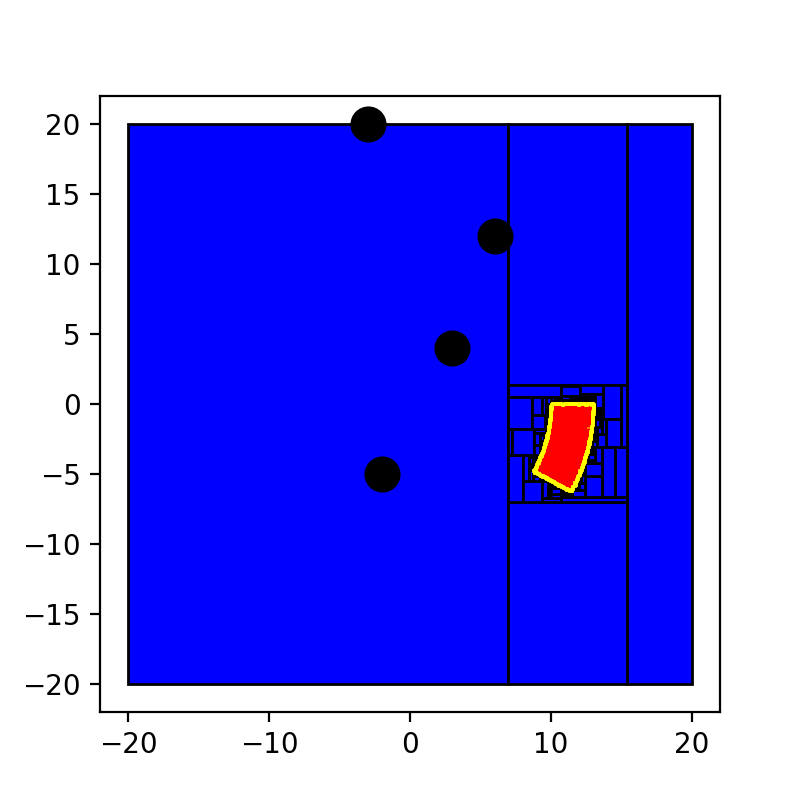

In [389]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
    
# draw the environment
for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
ax.autoscale()

## Rotating separators: how the SepTransform works

We have a Separator $Sep_X$ and a function $f: X->Y$ (for which we have an inclusion function) and we also have a function $f^{-1}: Y ->X$ (and the corresponding inclusion function).

We now want to build a $Sep_Y$ from the $Sep_X$.
Given a Box in $X$ we use the $Sep_X$ to build an inner and outer approximation (and hence to remove the unwanted parts of the box), which is another box.

Applying $[f]$ to this box, we obtain another box in $Y$, $b_Y$. Applying the $Sep_Y$ to the new box $b_Y$ we again obtain a smaller box as inner and outer approximation.

To build the separator $Sep_Y$ we need to have an inclusion function for $f$ and for $f^-1$ and the $Sep_X$.

![rotating-separators](pics/csp/rotating-separators.png)

In our case, we have that given the known landmark $m$:

$m = p + v$, 

where $p$ is the $(x,y)$ position of the robot, and $v=[v_x, v_y]$, with $v_x=d*cos(\alpha)$, and $v_y=d*sin(\alpha)$.

Since we want to know the position of the robot $p$, we can:

$p = m-v$  (since $m$ is know, the function $f: (m-v) -> p$)  
$v = m-p$  (this corresponds to $f^-1$).

We have a separator for $v$ (it is our "pie") and we can use the above equations to rotate it as appropriate.

And we do this for every landmark.

We can now program the robot localization:

In [390]:
landmarks = [[6, 12], [-2, -5], [-3, 10], [3, 4]]
ds = [Interval(10, 13), Interval(8, 10), Interval(5, 7), Interval(6, 8)]
alphas = [Interval(0.5, 1), Interval(-3, -1.5), Interval(1, 2), Interval(2, 3)]


In [391]:
m = landmarks[0] # this is (x, y)

# we define a rotation matrix and set p1, p2 as the position of the robot.
# This will give us an approx of the set of values of v = (v_x, v_y)
f_forward = Function('v_x', 'v_y', '(%f-v_x; %f-v_y)' % (m[0], m[1]))

# This will give us an approx of the set of values of p = (p_x, p_y)
f_inverse = Function('p_x', 'p_y', '(%f-p_x; %f-p_y)' % (m[0], m[1]))

# the new separator is rotated by -1 rad.
separator_rob = SepTransform(separator, f_forward, f_inverse)

In [392]:
in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator_rob, epsilon=0.1, draw_boxes=False) 

number of separation 409 / number of boxes 632


<IPython.core.display.Javascript object>


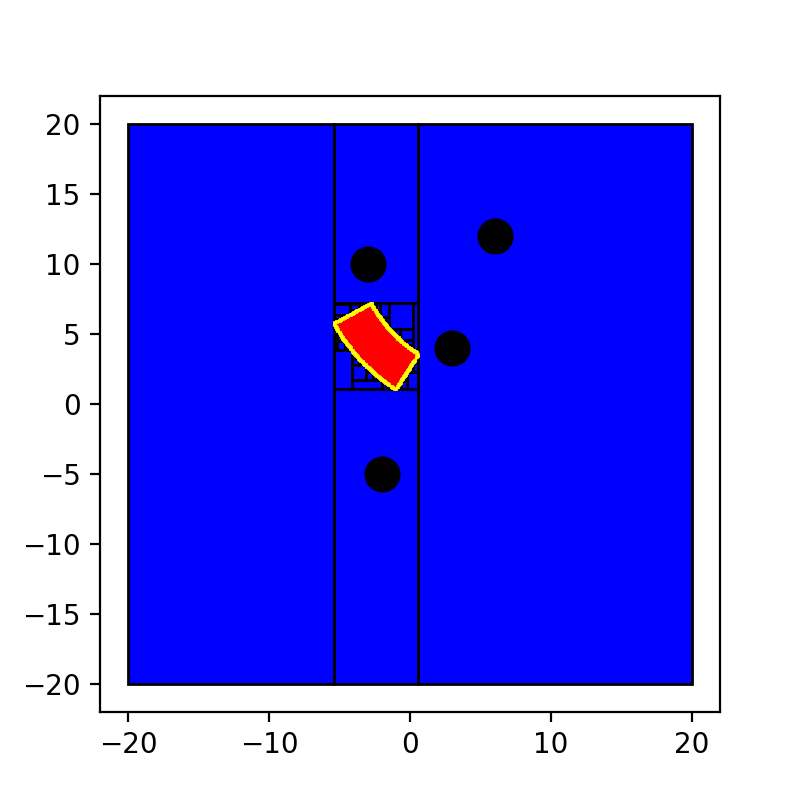

In [393]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
    
# draw the environment
for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
ax.autoscale()

The picture above shows the position of the robot that are consistent with the first landmark $m_1=[6,12]$.

Let's now localise the robot using the entire measurement set, possibly relaxing it if there are outliers.

In [394]:
separators = []

for m, d, alpha in zip(landmarks, ds, alphas):
    separator = SepPolarXY(d, alpha)
    
    f_forward = Function('v_x', 'v_y', '(%f-v_x; %f-v_y)' % (m[0], m[1]))
    f_backward = Function('p_x', 'p_y', '(%f-p_x; %f-p_y)' % (m[0], m[1]))

    separator_t = SepTransform(separator, f_backward, f_forward)
    separators.append(separator_t)
    

# build the final separator using the q relaxed intersection
separator = SepQInterProjF(separators)
separator.q = 1

In [395]:
in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.1, draw_boxes=False) 

number of separation 209 / number of boxes 319


<IPython.core.display.Javascript object>


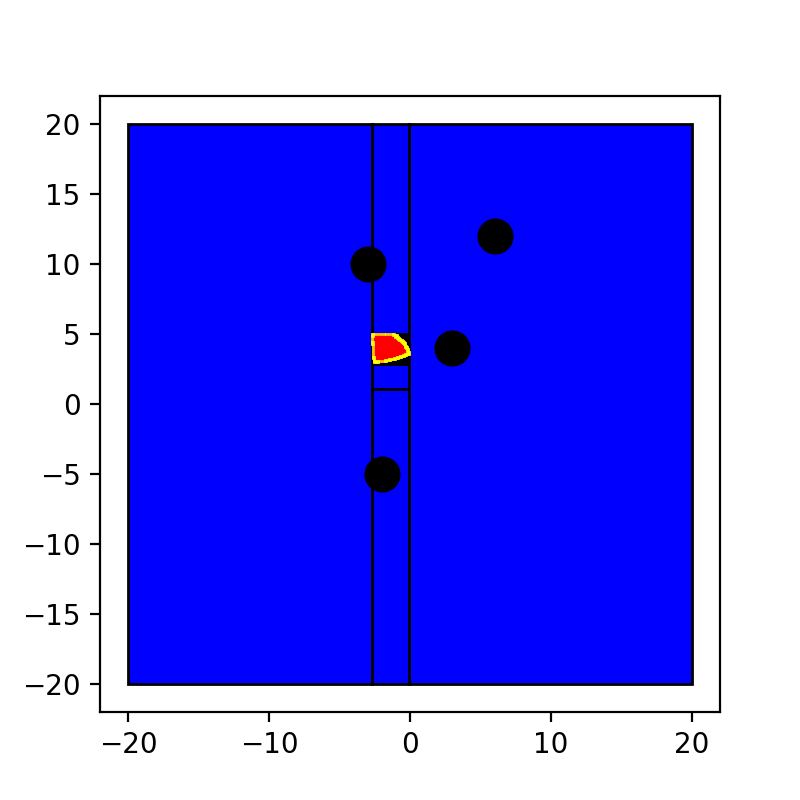

In [396]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
    
# draw the environment
for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
ax.autoscale()

The picture above gives us the set of the robot locations that are consistent with the measurements (number of measurements defined by the parameter `q` of the final separator).

If we set `q=3` we find the set of robot location that is consistent with at least one data (we are relaxing up to 3 sets and we have four measurements), so it is the union of all the measurements. This is done below:

In [399]:
# build the final separator using the q relaxed intersection
separator = SepQInterProjF(separators)
separator.q = 3

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.1, draw_boxes=False) 

number of separation 1333 / number of boxes 2031


<IPython.core.display.Javascript object>


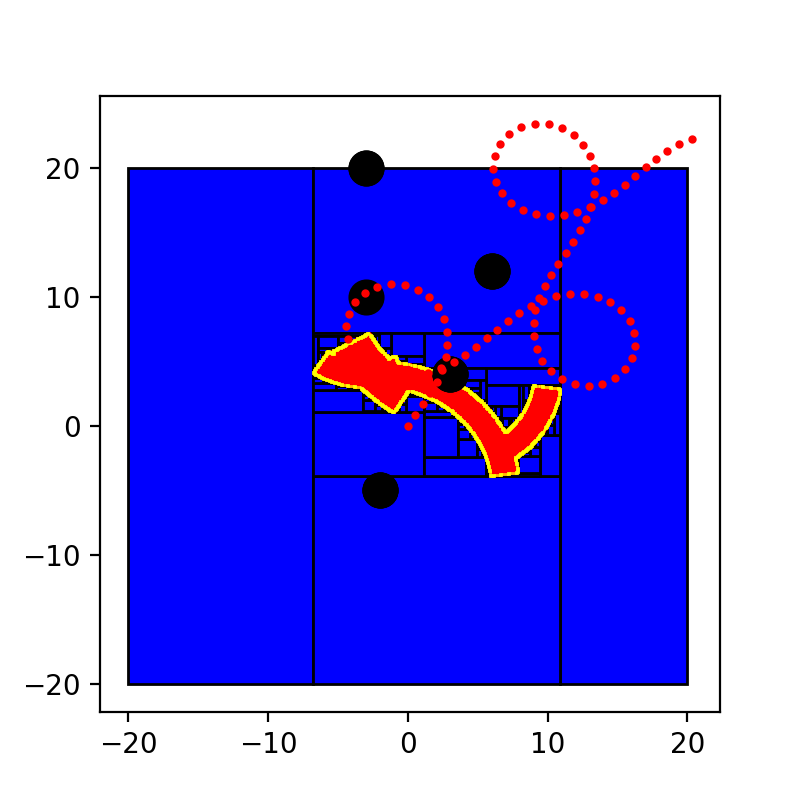

In [400]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='red', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
    
# draw the environment
for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
ax.autoscale()

From this picture is clear that we cannot be consistent with all measurements. In fact, the last measurement is an outlier.

# Simultaneous Localization and Mapping using pyibex 

Consider a robot at position $(x,y)$ moving inside an unknown environment. We assume that its motion is described by the discrete time state equations:

$x(k+1) = x(k)+10\delta·cos\theta(k)$  
$y(k+1) = y(k)+10\delta·sin\theta(k)$  
$\theta(k+1) = \theta(k)+\delta(u(k)+n_u(k))$

where $k \in \{0,...,100\}$ is the discrete time, 
$\delta = 0.1$ corresponds to the sampling time, 
$\theta$ to the heading, 
$u$ to the desired rotational speed and 
$n_u$ to a noise. 
We assume that at time k = 0, we have $x(k) = y(k) = 0$ and $\theta(k) = 1$. 

Note that the previous equations correspond to the case where the robot has a constant speed of 10 which we cannot control.

The desired input $u(k)$ is chosen as:
$u(k) = 3sin^2(k\delta)$

We assume that the heading is measured (using a compass for instance) with a small error:
$θ^m (k) = \theta(k) + n_{\theta}(k) $.


For all $k$ we assume that $n_{u}(k)$ and $n_{\theta}(k)$ belong to $[−0.03, 0.03]$.

We assume that we have 4 landmarks, the coordinate of which are given by the following table:

|   i   |     0   |     1    |     2    |    3   |
|-------|---------|----------|----------|--------|
|$m_i$ | (6, 12) | (−2, −5) | (−3, 20) | (3, 4) | 

For each k the robot is able to measure the distance to one of these landmarks (taken randomly), with an accuracy of ±0.03.

In [36]:
import random
import numpy as np

ks = range(0, 100)

landmarks = [[6,12], [-2,-5], [-3, 20], [3,4]]

here is the motion model of the robot:

In [37]:
def robot(dt, x, y, theta, v, u, n_u):
    xp1 = x + v*dt*np.cos(theta)
    yp1 = y + v*dt*np.sin(theta)
    thetap1 = theta + dt*(u+n_u)
    return xp1, yp1, thetap1

We define a utility function (we could have used one of np):

In [38]:
def rand_interval(i):
    x = i.lb() + random.random()*(i.ub()-i.lb())
    return x

In [39]:
noise = 0.03*Interval(-1, 1)
print(rand_interval(noise))
print(random.uniform(-0.03, 0.03))

0.006213581930122933
-0.019011598545177692


We initialise the simulation:

In [156]:
_x, _y, _th, dt = 0, 0, 1, 0.1

noise = 0.03*Interval(-1, 1)

x_hist, y_hist, th_hist = [_x], [_y], [_th + noise]    

Run the simulation to have the ground truth

In [ ]:
for k in ks:
    v   = 10
    u   = 3*np.sin(k*dt)**2
    #n_u = random.uniform(-0.03, 0.03)
    n_u = rand_interval(noise)

    _x, _y, _th = robot(dt, _x, _y, _th, v, u, n_u)
    x_hist.append(_x), y_hist.append(_y), th_hist.append(_th + noise)

<IPython.core.display.Javascript object>


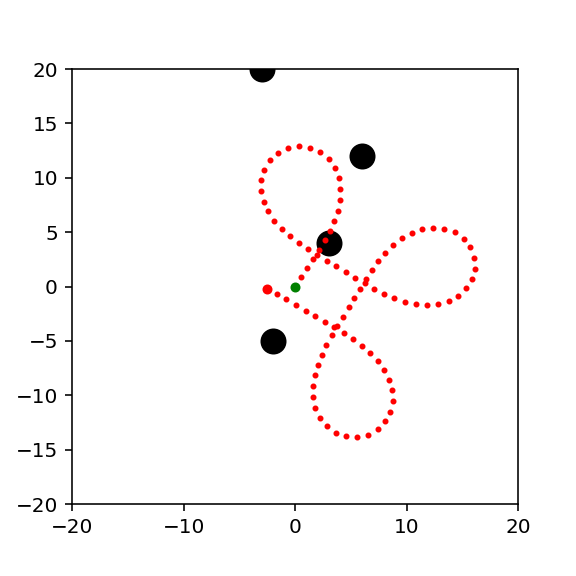

(-20, 20)

In [157]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))


for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)

for x, y in zip(x_hist, y_hist):   
    plt.plot(x, y, color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0], y_hist[0], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1], y_hist[-1], color='red', marker='.', markersize=8)

ax.autoscale()
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

### Calculate the interval envelope

In [162]:
def contract_state(xp1, yp1, x, y, th, v):
    """Contraction. The following vars are linked by a relation (hence we can contract them)
     and the relation is the state model
     note that theta is measured because we have a compass.
     If we do not have compass than we can return theta as well and contract it! 
     """
    fx = Function('xp1', 'x', 'th', 'xp1-x-%f*%f*cos(th)' % (dt, v))
    fy = Function('yp1', 'y', 'th', 'yp1-y-%f*%f*sin(th)' % (dt, v))

#     fx = Function("x_1", "x", "th", "x_1-x-%f*10*cos(th)" % dt)
#     fy = Function("y_1", "y", "th", "y_1-y-%f*10*sin(th)" % dt)
    
    
    contract_x = CtcFwdBwd(fx, Interval(0,0)) # This means fx==0
    contract_y = CtcFwdBwd(fy, Interval(0,0)) # This means fy==0    
    
    # ask the contractors to contract the intervals
    Bx = IntervalVector(3)  # 3 dimentions
    Bx[0], Bx[1], Bx[2] = xp1, x, th
    contract_x.contract(Bx) # result will be in B_x
    xp1, x, th = Bx[0], Bx[1], Bx[2] # store and update variables
    
    By = IntervalVector(3)
    By[0], By[1], By[2] = yp1, y, th
    contract_y.contract(By)
    yp1, y, th = By[0], By[1], By[2]    
        
    return xp1, yp1, x, y

In [163]:
# define our initial environment per each time step.
X = [ Interval(-20, 20) for i in range(0, ks[-1]+1) ] # list of 101 intervals ks[-1] is the final time
# initial position (known)
X[0] = Interval(x_hist[0])
Y = X.copy()

# here we need every Th to be an interval that contains the true value for theta
Th = [th_hist[i] for i in range(0,ks[-1]+1)] 

In [ ]:
# interval propogation
for k in ks:
    # contraction. The following vars are linked by a relation (hence we can contract them)
    # and the relation is the state model
    # note that theta is measured because we have a compass.
    # If we do not have compass than we can return theta as well and contract it!
    # v is also know as it is the vehicle speed.
    X[k], Y[k], X[k-1], Y[k-1] = contract_state(X[k], Y[k], X[k-1], Y[k-1], Th[k-1], v)

<IPython.core.display.Javascript object>


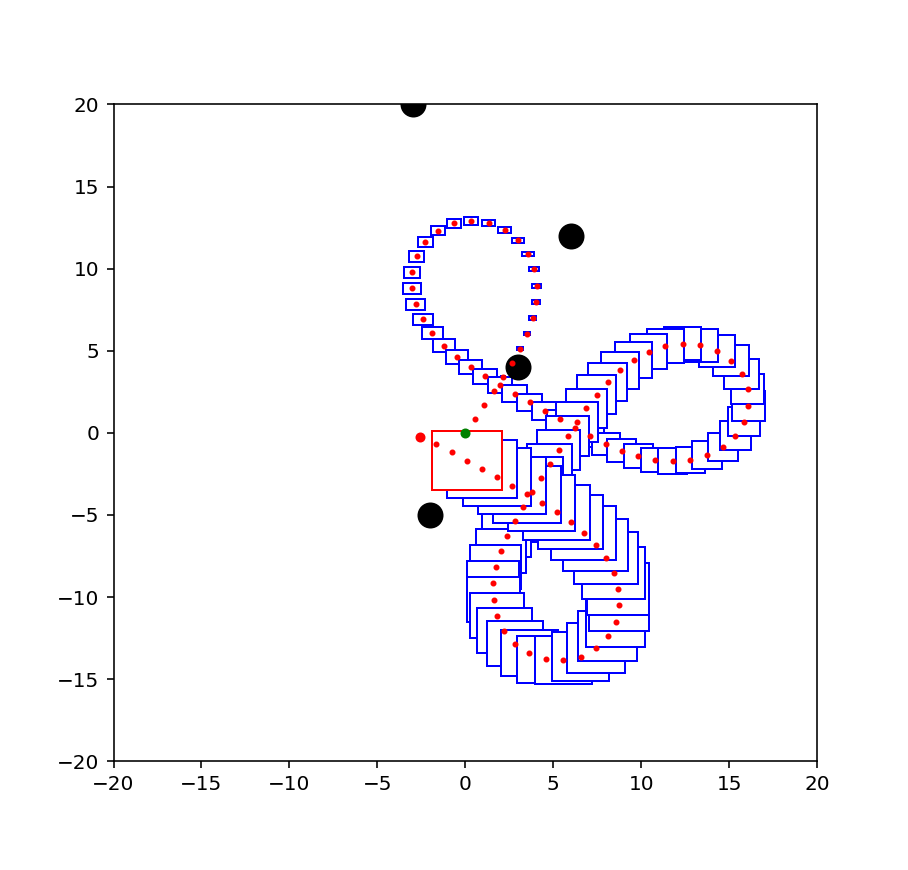

In [164]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
for x, y in zip(x_hist, y_hist):   
    plt.plot(x, y, color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0], y_hist[0], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1], y_hist[-1], color='red', marker='.', markersize=8)
    

for x, y in zip(X, Y):
    draw_box(IntervalVector([x,y]), edgecolor='blue', facecolor='white')


draw_box(IntervalVector([X[1],Y[1]]), edgecolor='green', facecolor='white')    
draw_box(IntervalVector([X[-3],Y[-3]]), edgecolor='red', facecolor='white')    

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

**NOTE: THE LAST TWO BOXES ARE EMPTY BUT I AM NOT SURE WHY!**

Let's now use the landmark but we assume that we do not know where they are.

Every time that the robot sees a landmark it can localise with an uncertainty that depends on its own navigation uncertainty.  
It is when it encounter landmark again that can reduce its uncertainty and the landmarks as well. Especially because we can then back prop the solution.

It is a fixed point problem that can be solved using constrain programming.

First, let's modify the previous code to include the distance measurements from the landmarks

In [169]:
_x, _y, _th, dt = 0, 0, 1, 0.1

noise = 0.03*Interval(-1, 1)

x_hist, y_hist, th_hist = [_x], [_y], [_th + noise]
land_hist = []
d_hist = []

for k in ks:
    # we select a random landmark that the robot will see at each time
    j = random.randint(0,3)
    land_hist.append(j)
    
    # distance between robot and landmark
    _d = np.sqrt((landmarks[j][0]- _x)**2 + (landmarks[j][1]- _y)**2)
    
    # Here are the measurements.
    # We add noise and we make it an interval which contains the true value
    d_hist.append(_d + rand_interval(noise) + noise) 
    
    v   = 10
    u   = 3*np.sin(k*dt)**2
    #n_u = random.uniform(-0.03, 0.03)
    n_u = rand_interval(noise)

    _x, _y, _th = robot(dt, _x, _y, _th, v, u, n_u)
    x_hist.append(_x), y_hist.append(_y), th_hist.append(_th + noise)    

Again, we modify the previous code to include the initial knowledge on the landmark positions.  
In this case, we use the same initial intervals that we used for the robot position (-20, 20), but if their position is totally unknown we can use (-inf, inf).

In [173]:
# define our initial environment per each time step.
X = [ Interval(-20, 20) for i in range(0, ks[-1]+1) ] # list of 101 intervals ks[-1] is the final time
Y = [ Interval(-20, 20) for i in range(0, ks[-1]+1) ]
# initial position (known)
X[0] = Interval(x_hist[0])
Y[0] = Interval(y_hist[0])

# Init landmark positions
# list of 4 initial intervals because we have 4 landmarks
Mx = [Interval(-20,20)]*4  
My = [Interval(-20,20)]*4

We now need to define the new contractor:

In [174]:
def contract_landmarks(x, y, mx, my, d):
    # we define the function to use to contract which is simply the distance.
    f = Function('x', 'y', 'mx', 'my', '(x-mx)^2 + (y-my)^2')
        
    contract_d = CtcFwdBwd(f, sqr(d)) # This means f==d (note that d is an interval)
    
    # ask the contractors to contract the intervals
    box = IntervalVector(4)  # dimentions 4 because we have 4 variables
    box[0], box[1], box[2], box[3] = x, y, mx, my
    contract_d.contract(box) # result will be in box
    x, y, mx, my = box[0], box[1], box[2], box[3]  # store and update variables
    
    return x, y, mx, my

In [175]:
# here we need every Th to be an interval that contains the true value for theta
Th = [th_hist[i] for i in range(0,ks[-1]+1)] 

# interval propagation
for k in range(1, ks[-1]+1):
    # contraction. The following vars are linked by a relation (hence we can contract them)
    # and the relation is the state model
    # note that theta is measured because we have a compass.
    # If we do not have compass than we can return theta as well and contract it!
    # v is also know as it is the vehicle speed.
    X[k], Y[k], X[k-1], Y[k-1] = contract_state(X[k], Y[k], X[k-1], Y[k-1], Th[k-1], v)

# contract the trajectory with respect to the landmarks
for k in range(0, ks[-1]):
    j = land_hist[k] # select the correct landmark seen at time k    
    X[k], Y[k], Mx[j], My[j] = contract_landmarks(X[k], Y[k], Mx[j], My[j], d_hist[k])

<IPython.core.display.Javascript object>


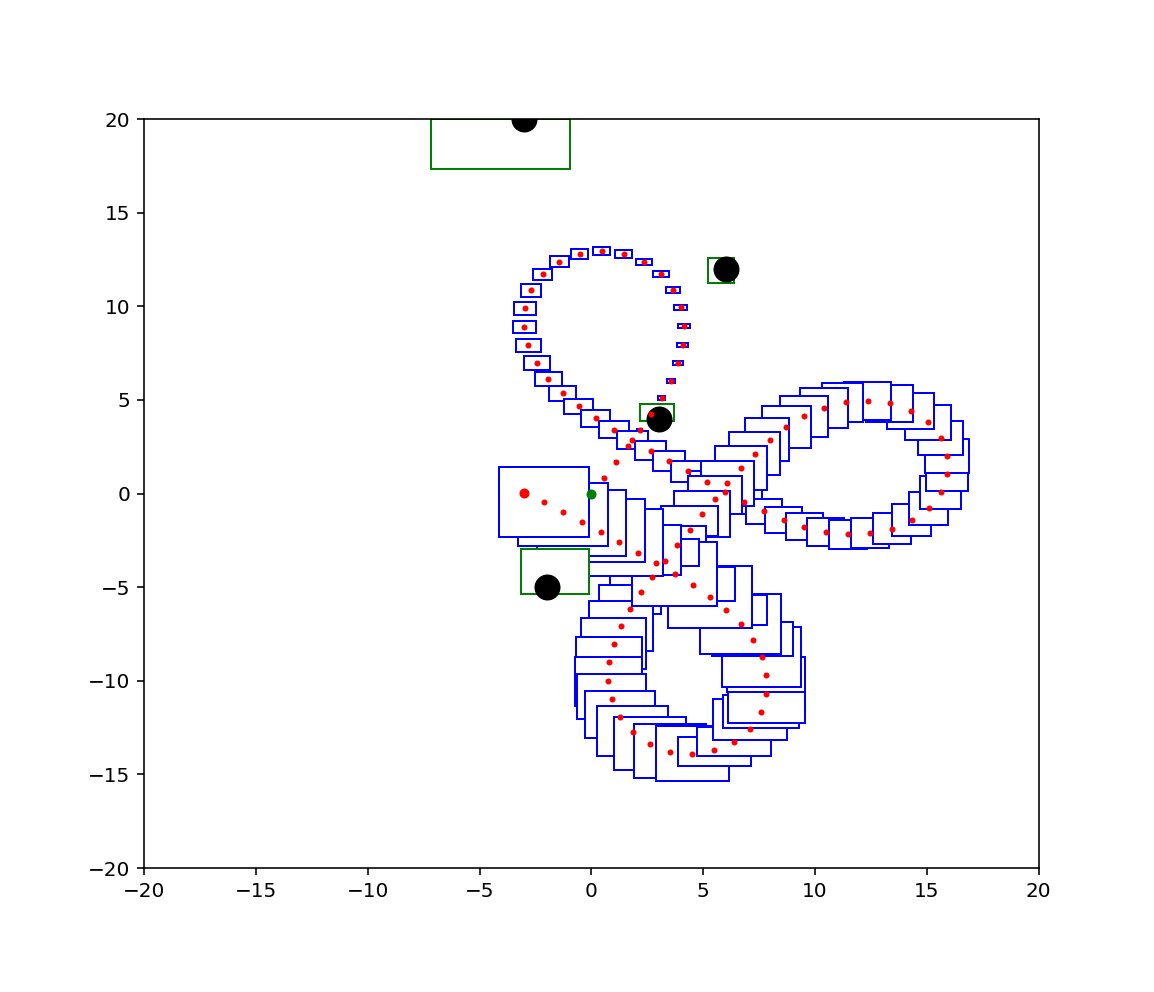

In [176]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
for x, y in zip(x_hist, y_hist):   
    plt.plot(x, y, color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0], y_hist[0], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1], y_hist[-1], color='red', marker='.', markersize=8)
    
# boxes of the positions
for x, y in zip(X, Y):
    draw_box(IntervalVector([x,y]), edgecolor='blue', facecolor='white')

for j in range(0, 4):
    draw_box(IntervalVector([Mx[j],My[j]]), edgecolor='green', facecolor='white')


ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

In this case we have contracted the landmarks but the trajectory has not been contracted again.

To improve the performance we need to solve the fix point problem and run trajectory and landmark contractions multiple times (until the fix point):

In [184]:
# here we need every Th to be an interval that contains the true value for theta
Th = [th_hist[i] for i in range(0,ks[-1]+1)] 

fix_point_iter = 5

for n in range(0, fix_point_iter):
    # interval propogation
    for k in range(1, ks[-1]+1):
        # contraction. The following vars are linked by a relation (hence we can contract them)
        # and the relation is the state model
        # note that theta is measured because we have a compass.
        # If we do not have compass than we can return theta as well and contract it!
        # v is also know as it is the vehicle speed.
        X[k], Y[k], X[k-1], Y[k-1] = contract_state(X[k], Y[k], X[k-1], Y[k-1], Th[k-1], v)

    # contract the trajectory with respect to the landmarks
    for k in range(0, ks[-1]):
        j = land_hist[k] # select the correct landmark seen at time k    
        X[k], Y[k], Mx[j], My[j] = contract_landmarks(X[k], Y[k], Mx[j], My[j], d_hist[k])

<IPython.core.display.Javascript object>


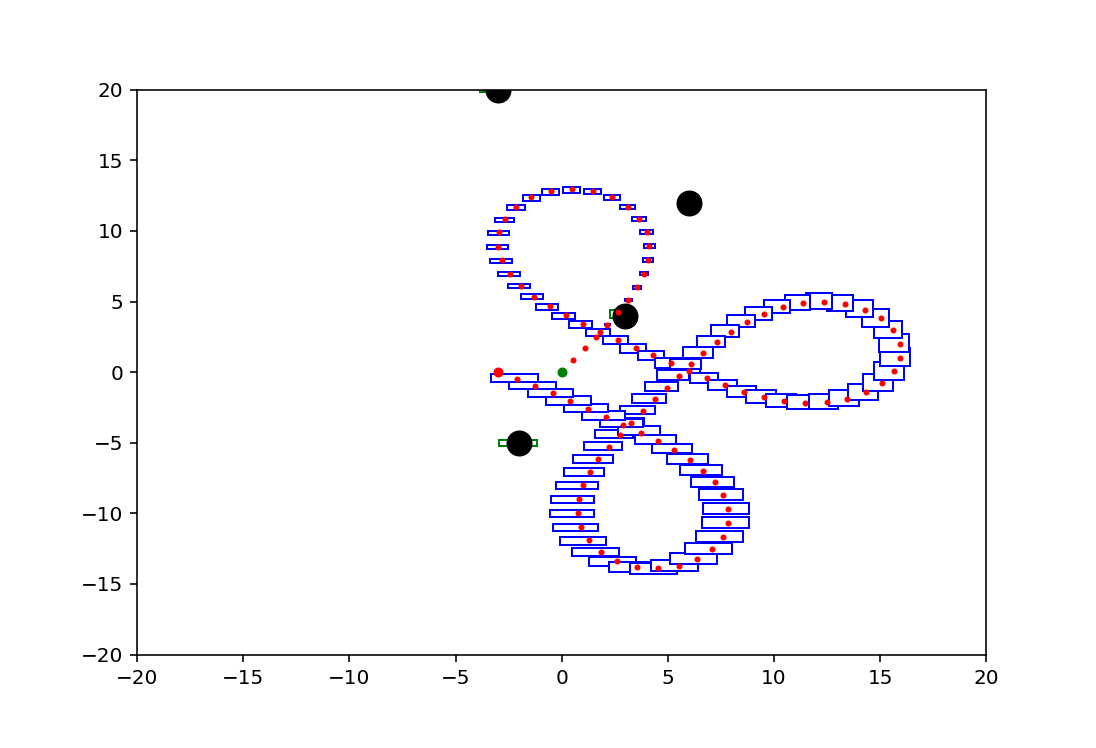

In [185]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
for x, y in zip(x_hist, y_hist):   
    plt.plot(x, y, color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0], y_hist[0], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1], y_hist[-1], color='red', marker='.', markersize=8)
    
# boxes of the positions
for x, y in zip(X, Y):
    draw_box(IntervalVector([x,y]), edgecolor='blue', facecolor='white')

for j in range(0, 4):
    draw_box(IntervalVector([Mx[j],My[j]]), edgecolor='green', facecolor='white')


ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

To have an even better solution we can apply an adidtional contraction that runs the trajectory backwards:

In [181]:
# here we need every Th to be an interval that contains the true value for theta
Th = [th_hist[i] for i in range(0,ks[-1]+1)] 

fix_point_iter = 5

for n in range(0, fix_point_iter):
    # interval propogation
    for k in range(1, ks[-1]+1):
        # contraction. The following vars are linked by a relation (hence we can contract them)
        # and the relation is the state model
        # note that theta is measured because we have a compass.
        # If we do not have compass than we can return theta as well and contract it!
        # v is also know as it is the vehicle speed.
        X[k], Y[k], X[k-1], Y[k-1] = contract_state(X[k], Y[k], X[k-1], Y[k-1], Th[k-1], v)

    # Here we do one more contraction backwards.
    for k in range(ks[-1], 0, -1):
        X[k], Y[k], X[k-1], Y[k-1] = contract_state(X[k], Y[k], X[k-1], Y[k-1], Th[k-1], v)


        
    # contract the trajectory with respect to the landmarks
    for k in range(0, ks[-1]):
        j = land_hist[k] # select the correct landmark seen at time k    
        X[k], Y[k], Mx[j], My[j] = contract_landmarks(X[k], Y[k], Mx[j], My[j], d_hist[k])

<IPython.core.display.Javascript object>


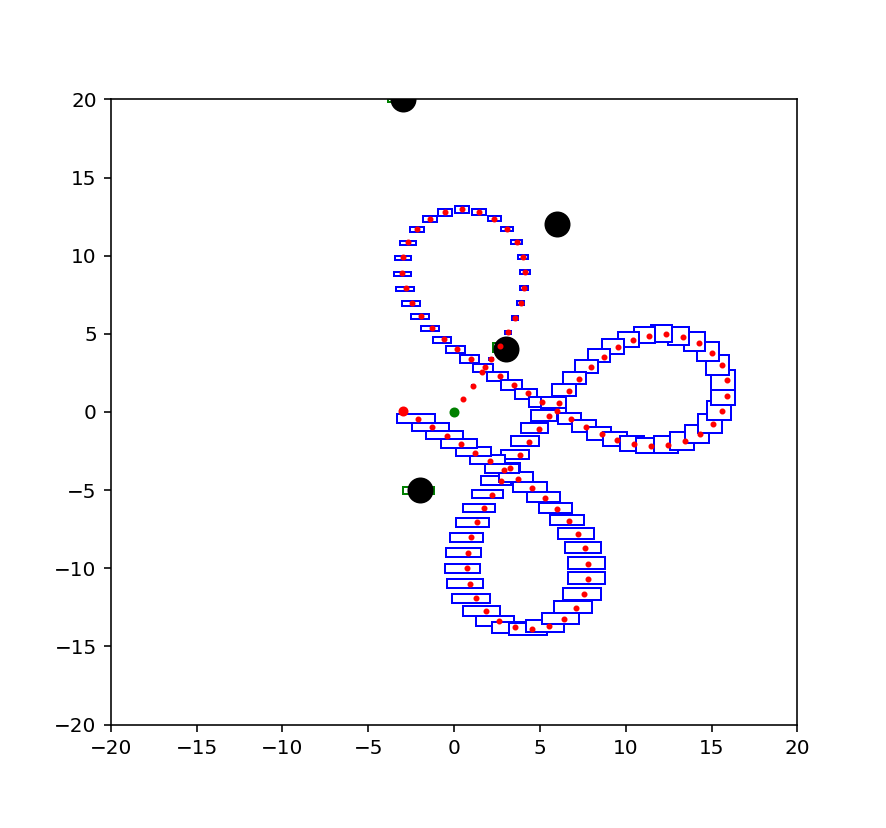

In [183]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for m in landmarks:
    plt.plot(m[0], m[1], color='black', marker='o', markersize=12)
    
for x, y in zip(x_hist, y_hist):   
    plt.plot(x, y, color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0], y_hist[0], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1], y_hist[-1], color='red', marker='.', markersize=8)
    
# boxes of the positions
for x, y in zip(X, Y):
    draw_box(IntervalVector([x,y]), edgecolor='blue', facecolor='white')

for j in range(0, 4):
    draw_box(IntervalVector([Mx[j],My[j]]), edgecolor='green', facecolor='white')


ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

-----------------------------------

# References 

[Moo66] RE Moore (1966), Interval analysis, Prentice-Hall.

[Group localisation using matrix contractors](https://www.youtube.com/watch?v=pM0et6fsMQ4)

# Fin.

In [237]:
# Let's see if I can plot an ellipse now
X = IntervalVector([[-10, 10], [-10, 10]]) 

x_0 = Interval(2, 3)
y_0 = Interval(0, 0)
a = 4 #Interval(4, 5) # major semiaxis
b = 2 #Interval(2, 3) # minor semiaxis

#f = Function("x1", "x2", "(x1-[1,1.3])^2 + (x2-[2,2.3])^2")

f = Function("x", "y", "(x-[1,1.3])^2/4^2 + (y-[2, 2.3])^2/2^2")
 
separator = SepFwdBwd(f, Interval(1, 2))

in_boxes, out_boxes, maybe_boxes = pySIVIA(X, separator, epsilon=0.2, draw_boxes=False) 

number of separation 2049 / number of boxes 1672


<IPython.core.display.Javascript object>


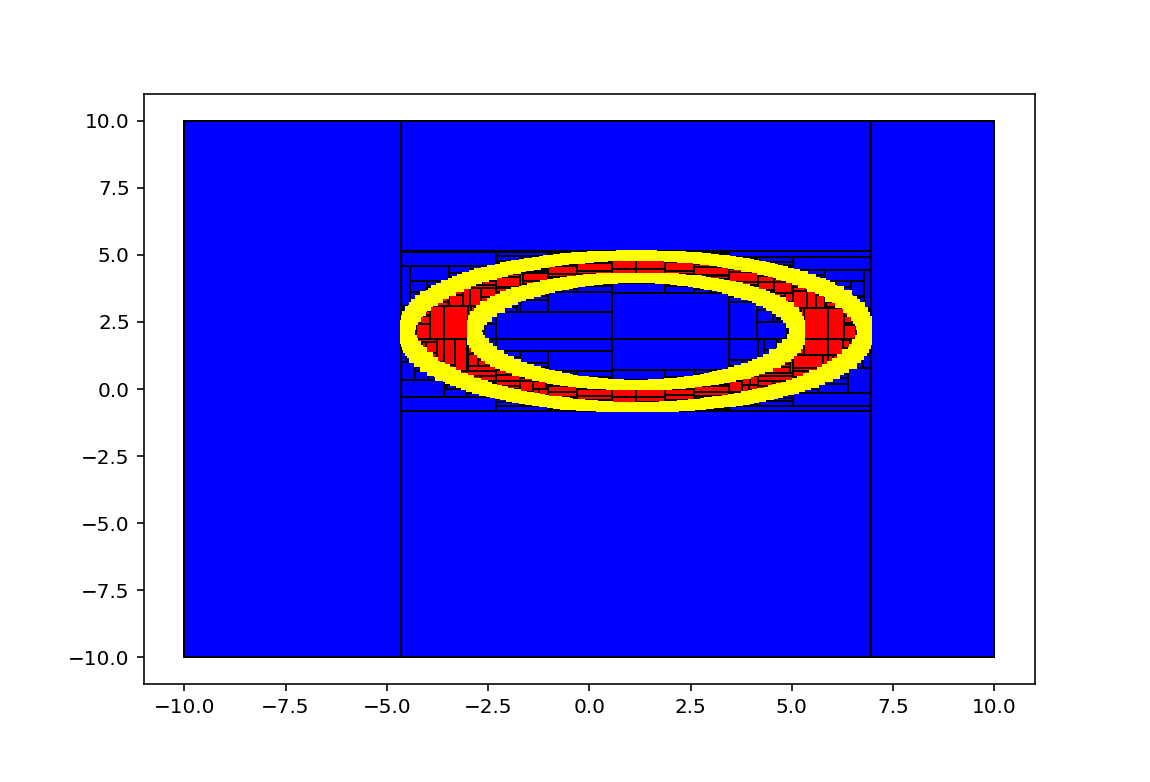

In [238]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes:
    draw_box(b, edgecolor='black', facecolor='blue', ax=ax)
    
for b in in_boxes:
    draw_box(b, edgecolor='black', facecolor='red', ax=ax)
    
for b in maybe_boxes:
    draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
    
# ax.set_xlim(-2, 6)
# ax.set_ylim(-2, 2)

In [246]:
_draw_box??

<IPython.core.display.Javascript object>


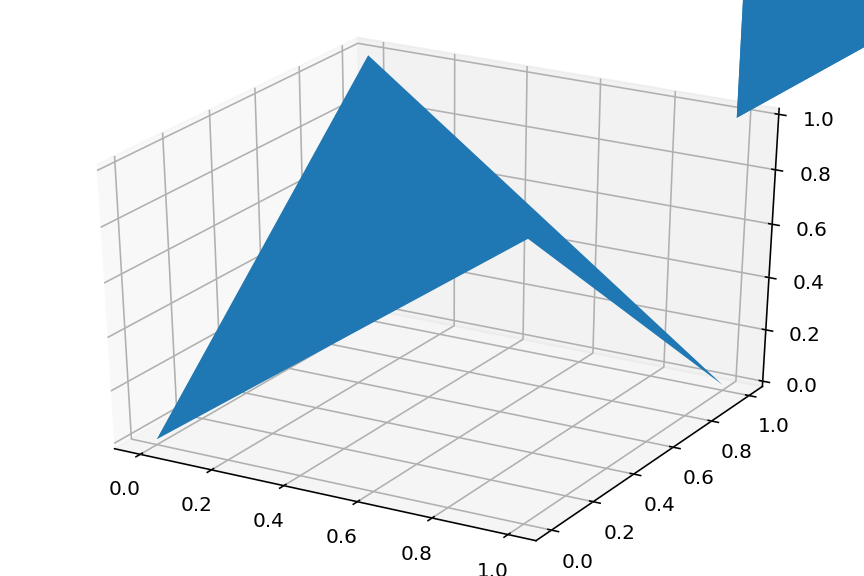

In [245]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()

ax = Axes3D(fig)
x = [0,1,1,0]
y = [0,0,1,1]
z = [0,1,0,1]

verts = [list(zip(x,y,z))]
ax.add_collection3d(Poly3DCollection(verts), zs=z)
plt.show()

In [259]:
def _draw_box_3d(x_lo, x_up, y_lo, y_up, z_lo, z_up, edgecolor='black', facecolor='blue', ax=None):
    if ax is None: ax = plt.gca()        
    xy = (x_lo,y_lo)    
    width_1 = x_up-x_lo
    width_2 = y_up-y_lo
    height = z_up-z_lo
    
    x = [x_lo,x_lo,x_lo,x_lo,x_lo,x_lo, x_up,x_up,x_up,x_up]
    y = [y_lo,y_lo,y_up,y_up,y_up,y_up,y_lo,y_lo]
    z = [z_lo,z_up,z_up,z_lo,z_lo,z_up,z_up,z_lo]

    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts), zs=z)
    ax.autoscale()
    return ax

<IPython.core.display.Javascript object>


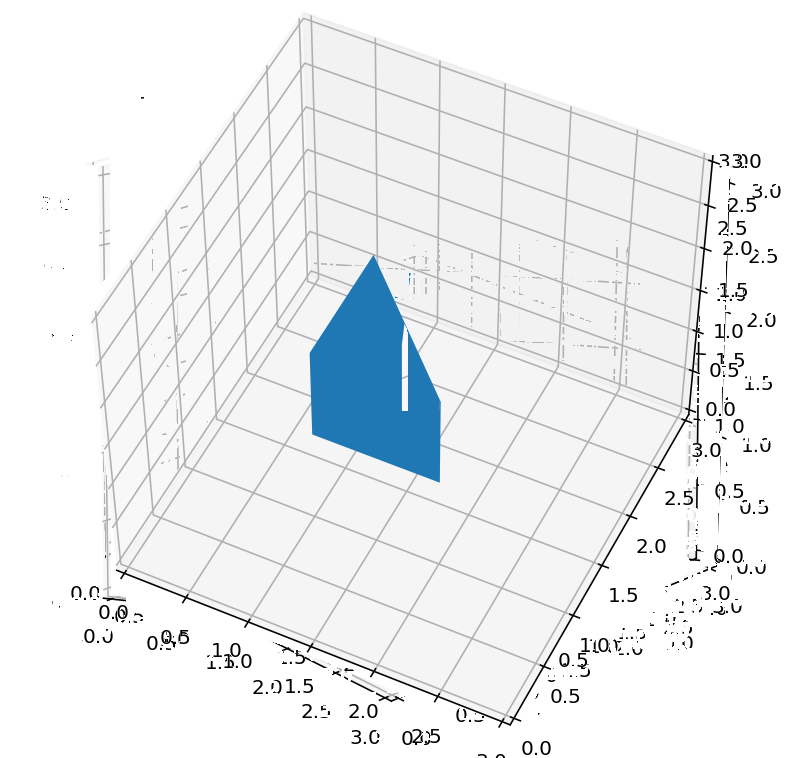

(0, 3)

In [260]:
fig = plt.figure()
ax = Axes3D(fig)
_draw_box_3d(1,2,1,2,1,2)
ax.set_xlim(0,3)
ax.set_ylim(0,3)
ax.set_zlim(0,3)